In [1]:
import numpy as np
import vast.io_mesh as io
import vast.surface_tools as st

Setting civet_path to /data1/quarantines/Linux-x86_64/bin/


In [534]:
origin_offset=[-70.66, -72.51, -58.77778]
resolution=[0.1,0.1,0.1]
dimensions=[500, 500, 500]
g_surf = io.load_mesh_geometry('surface_data/obj_surfaces/gray_left_rsl_327680.obj')
w_surf = io.load_mesh_geometry('surface_data/obj_surfaces/white_left_rsl_327680.obj')

In [527]:
def generate_prism(g_coords,w_coords,triangle):
    """return coordinates for prism in a dictionary
    with two triangles
    ordering is g1,g2,g3 - w1,w2,w3"""
    prism_coordinates={'g_triangle':g_coords[triangle],'w_triangle':w_coords[triangle]}
    return prism_coordinates

def prism_bounding_box(prism):
    """returns the two defining corners of a box enclosing the prism.
    i.e. the minimum and maximum values in the 3 dimensions."""
    mins=np.min(np.vstack((prism['g_triangle'],prism['w_triangle'])),axis=0)
    maxs=np.max(np.vstack((prism['g_triangle'],prism['w_triangle'])),axis=0)
    return mins, maxs

def voxel_world_coords_in_box(box, origin_offset, voxel_resolution, dimensions):
    """calculate which voxels from a block/slice/volume are located a box (world coordinates)
    returns coordinates of voxels and voxel indices
    Assumes axis orderings of box, origin_offset, voxel resolution and dimensions are all the same
    Usually xyz"""
    #calculate box corners in voxel indices. Ensure voxel coordinates are non-negative and do not
    #exceed volume limits
    indices_min = np.min((np.max((np.floor((box[0] - origin_offset)/resolution),[0,0,0]),axis=0),dimensions),axis=0).astype(int)
    indices_max = np.min((np.max((np.ceil((box[1]- origin_offset)/resolution), [0,0,0]), axis=0),dimensions), axis=0).astype(int)
    if (indices_min == indices_max).all():
        #box not in volume block.
        #TODO test subsequent functionality
        return None, None
    
    #get a grid of coordinates
    voxel_coordinates=np.mgrid[indices_min[0]:indices_max[0],
         indices_min[1]:indices_max[1],
        indices_min[2]:indices_max[2]].T
    voxel_coordinates = np.reshape(voxel_coordinates,(voxel_coordinates.size//3,3))
    #convert to world coordinates
    world_coordinates=origin_offset+voxel_coordinates*resolution
    return world_coordinates, voxel_coordinates

def get_exact_depth(voxel_coord, prism, decimals=5):
    """returns exact coortical depth of point
    
    due to imprecisions in estimating roots of the cubic, it is advisable to round to desired accuracy.
    for 3mm cortex, decimals=5 gives an accuracy of 30 nanometers"""
    #solve for depth
    connecting_vectors = prism['w_triangle']-prism['g_triangle']
    connecting_inplane_vectors = np.array([connecting_vectors[2]-connecting_vectors[0],
                                           connecting_vectors[1]-connecting_vectors[0]])
    #k2 term of cp
    cross_product_connecting_vectors = np.cross(connecting_inplane_vectors[0],connecting_inplane_vectors[1])

    gray_inplane_vectors = np.array([prism['g_triangle'][2]-prism['g_triangle'][0],
                                     prism['g_triangle'][1]-prism['g_triangle'][0]])
    #const term of cp
    cross_product_gray_inplane_vectors = np.cross(gray_inplane_vectors[0],gray_inplane_vectors[1])

    #k term of cp
    cross_prod_gray_connecting1 = np.cross(gray_inplane_vectors[1], connecting_inplane_vectors[0])
    cross_prod_gray_connecting2 = np.cross(gray_inplane_vectors[0], connecting_inplane_vectors[1])
    cross_prod_gray_connecting_sum = -cross_prod_gray_connecting1+cross_prod_gray_connecting2

    g3 = prism['g_triangle'][2]
    v3 = connecting_vectors[2]

    k3 = np.dot(cross_product_connecting_vectors,v3)
    k2 = (np.dot(v3,cross_prod_gray_connecting_sum)+
         np.dot(cross_product_connecting_vectors,g3-voxel_coord))
    k1 = (np.dot(v3, cross_product_gray_inplane_vectors) +
         np.dot(cross_prod_gray_connecting_sum,g3-voxel_coord))
    k0 = (np.dot(cross_product_gray_inplane_vectors,g3-voxel_coord))
    depths = np.roots([k3,k2,k1,k0])
    depths = np.round(depths[np.isreal(depths)],decimals=decimals)
    depths = depths[np.logical_and(depths>=0,depths<=1.0)]

    return depths


def get_exact_depth_multiple_coordinates(voxel_coords,prism,decimals=5):
    """returns exact coortical depth of point
    
    due to imprecisions in estimating roots of the cubic, it is advisable to round to desired accuracy.
    for 3mm cortex, decimals=5 gives an accuracy of 30 nanometers"""
    #solve for depth
    connecting_vectors = prism['w_triangle']-prism['g_triangle']
    connecting_inplane_vectors = np.array([connecting_vectors[2]-connecting_vectors[0],
                                           connecting_vectors[1]-connecting_vectors[0]])
    #k2 term of cp
    cross_product_connecting_vectors = np.cross(connecting_inplane_vectors[0],connecting_inplane_vectors[1])

    gray_inplane_vectors = np.array([prism['g_triangle'][2]-prism['g_triangle'][0],
                                     prism['g_triangle'][1]-prism['g_triangle'][0]])
    #const term of cp
    cross_product_gray_inplane_vectors = np.cross(gray_inplane_vectors[0],gray_inplane_vectors[1])

    #k term of cp
    cross_prod_gray_connecting1 = np.cross(gray_inplane_vectors[1], connecting_inplane_vectors[0])
    cross_prod_gray_connecting2 = np.cross(gray_inplane_vectors[0], connecting_inplane_vectors[1])
    cross_prod_gray_connecting_sum = -cross_prod_gray_connecting1+cross_prod_gray_connecting2

    g3 = prism['g_triangle'][2]
    v3 = connecting_vectors[2]

    k3 = np.dot(cross_product_connecting_vectors,v3)
    all_depths=np.zeros(len(voxel_coords))
    for k, voxel_coord in enumerate(voxel_coords):
        k2 = (np.dot(v3,cross_prod_gray_connecting_sum)+
         np.dot(cross_product_connecting_vectors,g3-voxel_coord))
        k1 = (np.dot(v3, cross_product_gray_inplane_vectors) +
         np.dot(cross_prod_gray_connecting_sum,g3-voxel_coord))
        k0 = (np.dot(cross_product_gray_inplane_vectors,g3-voxel_coord))
        depths = np.roots([k3,k2,k1,k0])
        depths = np.round(depths[np.isreal(depths)],decimals=decimals)
        depths = depths[np.logical_and(depths>=0,depths<=1.0)]
        if len(depths)==0:
            all_depths[k]=float('NaN')
        else:
            all_depths[k]=depths[0]
    return all_depths


def barycentric_coordinates(p,tri):
    #solve to return coordinates as barycentric from 3 vertices of triangle.
    #Use outputs for linear interpolation
    a = (np.square(tri[0,0]-tri[2,0]) + np.square(tri[0,1]-tri[2,1]) + np.square(tri[0,2]-tri[2,2]))
    b = (tri[1,0]-tri[2,0])*(tri[0,0]-tri[2,0]) + (tri[1,1]-tri[2,1])*(tri[0,1]-tri[2,1]) + (tri[1,2]-tri[2,2])*(tri[0,2]-tri[2,2])
    c = b
    d = (np.square(tri[1,0]-tri[2,0]) + np.square(tri[1,1]-tri[2,1]) + np.square(tri[1,2]-tri[2,2]))
    f = (p[0] - tri[2,0])*(tri[0,0]-tri[2,0]) + (p[1]-tri[2,1])*(tri[0,1]-tri[2,1]) + (p[2]-tri[2,2])*(tri[0,2]-tri[2,2])
    g = (p[0] - tri[2,0])*(tri[1,0]-tri[2,0]) + (p[1]-tri[2,1])*(tri[1,1]-tri[2,1]) + (p[2]-tri[2,2])*(tri[1,2]-tri[2,2])
    chi = (d*f - b*g)/(a*d - b*c)
    eta = (-c*f + a*g)/(a*d - b*c)
    lambda1 = chi
    lambda2 = eta
    lambda3 = 1 - chi - eta
    return lambda1, lambda2, lambda3

def get_depth_and_barycentric_coordinates(world_coords,voxel_coords,prism):
    """calculate the precise depth and barycentric coordinates within a prism
    of all world coordinates
    depth - fractional depth from gray to white surface
    barycentric - fractional distance from each vertex in triangle"""
    depths = get_exact_depth_multiple_coordinates(world_coords,prism)
    #filter out coordinates not in the right depth
    world_coords = world_coords[~np.isnan(depths)]
    voxel_coords = voxel_coords[~np.isnan(depths)]
    depths=depths[~np.isnan(depths)]
    #calculate barycentric coordinates for remaining voxels
    vector=prism['w_triangle']-prism['g_triangle']
    barycentric_coords = np.zeros((len(depths),3))
    for k, (world_coord, depth) in enumerate(zip(world_coords,depths)):
        barycentric_coords[k] = barycentric_coordinates(world_coord, depth*vector +prism['g_triangle'])
    #filter out coordinates outside of triangle
    
    exclude=np.logical_or(np.any(barycentric_coords<0,axis=1),np.any(barycentric_coords>1,axis=1))
    world_coords = world_coords[~exclude]
    voxel_coords = voxel_coords[~exclude]
    depths=depths[~exclude]
    barycentric_coords=barycentric_coords[~exclude]
    return world_coords, voxel_coords, depths, barycentric_coords

In [528]:
com=np.mean(np.vstack((prism['g_triangle'],prism['w_triangle'])),axis=0)
world_coords=np.array([com,com])
get_depth_and_barycentric_coordinates(world_coords,world_coords,prism)

(array([[-45.44076667,  18.6699    ,   4.579945  ],
        [-45.44076667,  18.6699    ,   4.579945  ]]),
 array([[-45.44076667,  18.6699    ,   4.579945  ],
        [-45.44076667,  18.6699    ,   4.579945  ]]),
 array([0.5, 0.5]),
 array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]))

In [529]:
prism=generate_prism(g_surf['coords'], w_surf['coords'],triangle)
bbox = prism_bounding_box(prism)
world_coords, voxel_coords= voxel_world_coords_in_box(bbox,origin_offset, resolution, dimensions)


In [530]:
world_coords

array([[-46.36   ,  18.09   ,   4.02222],
       [-46.26   ,  18.09   ,   4.02222],
       [-46.16   ,  18.09   ,   4.02222],
       ...,
       [-44.86   ,  19.29   ,   5.22222],
       [-44.76   ,  19.29   ,   5.22222],
       [-44.66   ,  19.29   ,   5.22222]])

In [531]:
print(prism,world_coords,bbox)

{'g_triangle': array([[-44.7379 ,  18.2156 ,   4.09533],
       [-44.6407 ,  18.2997 ,   4.06897],
       [-44.678  ,  18.1716 ,   4.35543]]), 'w_triangle': array([[-46.3468 ,  19.0689 ,   4.79584],
       [-46.0479 ,  19.3209 ,   4.8976 ],
       [-46.1933 ,  18.9427 ,   5.2665 ]])} [[-46.36     18.09      4.02222]
 [-46.26     18.09      4.02222]
 [-46.16     18.09      4.02222]
 ...
 [-44.86     19.29      5.22222]
 [-44.76     19.29      5.22222]
 [-44.66     19.29      5.22222]] (array([-46.3468 ,  18.1716 ,   4.06897]), array([-44.6407,  19.3209,   5.2665]))


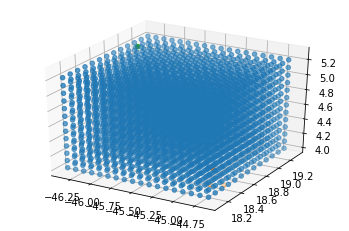

In [532]:

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(world_coords[:,0],world_coords[:,1],world_coords[:,2])
g=prism['g_triangle']
ax.scatter(g[:,0],g[:,1],g[:,2])
w=prism['w_triangle']
ax.scatter(w[:,0],w[:,1],w[:,2])

In [538]:
import time
t1=time.time()
block=np.zeros(dimensions)

for triangle in w_surf['faces']:
    prism=generate_prism(g_surf['coords'], w_surf['coords'],triangle)
    bbox = prism_bounding_box(prism)
    world_coords, voxel_coords= voxel_world_coords_in_box(bbox,origin_offset, resolution, dimensions)
    t3=time.time()
    wc, vc, depths, tri_coords=get_depth_and_barycentric_coordinates(world_coords,voxel_coords,prism)
    print(depths)
    t4=time.time()
    print(t4-t3)
t2=time.time()
t2-t1

[]
0.00025081634521484375
[]
0.00020933151245117188
[]
0.00033402442932128906
[]
0.00019049644470214844
[]
0.00018715858459472656
[]
0.000186920166015625
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.00019216537475585938
[]
0.00018715858459472656
[]
0.00019216537475585938
[]
0.000202178955078125
[]
0.00018262863159179688
[]
0.00021028518676757812
[]
0.00019121170043945312
[]
0.0003273487091064453
[]
0.0002009868621826172
[]
0.00021719932556152344
[]
0.00019598007202148438
[]
0.00020003318786621094
[]
0.00018405914306640625
[]
0.00018715858459472656
[]
0.00018477439880371094
[]
0.00018310546875
[]
0.00029659271240234375
[]
0.0001850128173828125
[]
0.00018024444580078125
[]
0.0001842975616455078
[]
0.00018548965454101562
[]
0.00018262863159179688
[]
0.00018334388732910156
[]
0.00018262863159179688
[]
0.0002434253692626953
[]
0.0001842975616455078
[]
0.0001862049102783203
[]
0.00019550323486328125
[]
0.0003685951232910156
[]
0.00018644332885742188
[]
0.00018548965454101562
[]
0.0

[]
0.0001938343048095703
[]
0.00020265579223632812
[]
0.00018525123596191406
[]
0.00018310546875
[]
0.0001823902130126953
[]
0.0002682209014892578
[]
0.00021767616271972656
[]
0.0002903938293457031
[]
0.0002048015594482422
[]
0.00020051002502441406
[]
0.00018644332885742188
[]
0.00018739700317382812
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.00019168853759765625
[]
0.00029397010803222656
[]
0.0001888275146484375
[]
0.00018525123596191406
[]
0.0001823902130126953
[]
0.0001823902130126953
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.00018215179443359375
[]
0.0001819133758544922
[]
0.00022411346435546875
[]
0.0001857280731201172
[]
0.0001823902130126953
[]
0.00018262863159179688
[]
0.0001819133758544922
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.00018835067749023438
[]
0.00038814544677734375
[]
0.0002086162567138672
[]
0.00019121170043945312
[]
0.00018477439880371094
[]
0.00018310546875
[]
0.0001823902130126953
[]
0.000183820

[]
0.00021767616271972656
[]
0.0001881122589111328
[]
0.0005049705505371094
[]
0.00019240379333496094
[]
0.0001811981201171875
[]
0.0001862049102783203
[]
0.00020933151245117188
[]
0.00018978118896484375
[]
0.0001842975616455078
[]
0.00018453598022460938
[]
0.00018405914306640625
[]
0.00018668174743652344
[]
0.00018167495727539062
[]
0.0001862049102783203
[]
0.00018525123596191406
[]
0.00018405914306640625
[]
0.00021195411682128906
[]
0.0001888275146484375
[]
0.00018668174743652344
[]
0.0002968311309814453
[]
0.0001823902130126953
[]
0.0002961158752441406
[]
0.0001842975616455078
[]
0.00018525123596191406
[]
0.00018286705017089844
[]
0.0002446174621582031
[]
0.00018644332885742188
[]
0.0002942085266113281
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.0001811981201171875
[]
0.00029754638671875
[]
0.00018548965454101562
[]
0.00018548965454101562
[]
0.00018358230590820312
[]
0.00018548965454101562
[]
0.00018644332885742188
[]
0.00018596649169921875
[]
0.0001838207244873047
[]
0

[]
0.00019168853759765625
[]
0.00021505355834960938
[]
0.0001888275146484375
[]
0.00020003318786621094
[]
0.00019121170043945312
[]
0.0002033710479736328
[]
0.00018715858459472656
[]
0.0001862049102783203
[]
0.00018644332885742188
[]
0.00018715858459472656
[]
0.00018215179443359375
[]
0.0001823902130126953
[]
0.000240325927734375
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.00018215179443359375
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.00018334388732910156
[]
0.00018310546875
[]
0.00020432472229003906
[]
0.00030994415283203125
[]
0.00019884109497070312
[]
0.00018405914306640625
[]
0.0001823902130126953
[]
0.00018739700317382812
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.0001823902130126953
[]
0.00018477439880371094
[]
0.0001862049102783203
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.00018215179443359375
[]
0.00019311904907226562
[]
0.00018310546875
[]
0.00018191337

[]
0.0001933574676513672
[]
0.00021648406982421875
[]
0.00018858909606933594
[]
0.00023055076599121094
[]
0.00021719932556152344
[]
0.00021314620971679688
[]
0.00037097930908203125
[]
0.00018906593322753906
[]
0.0001876354217529297
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.00018525123596191406
[]
0.0001838207244873047
[]
0.00018453598022460938
[]
0.00018477439880371094
[]
0.00023746490478515625
[]
0.00018262863159179688
[]
0.0001850128173828125
[]
0.00018262863159179688
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.00018405914306640625
[]
0.0001876354217529297
[]
0.00018525123596191406
[]
0.0001842975616455078
[]
0.00018453598022460938
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.00018143653869628906
[]
0.0002899169921875
[]
0.0001850128173828125
[]
0.0001876354217529297
[]
0.0001862049102783203
[]
0.00018548965454101562
[]
0.00019311904907226562
[]
0.00018787384033203125
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.0001900196075439453
[]
0.0001

[]
0.00021982192993164062
[]
0.0001888275146484375
[]
0.0001926422119140625
[]
0.00017952919006347656
[]
0.00018262863159179688
[]
0.0001983642578125
[]
0.00017690658569335938
[]
0.0001780986785888672
[]
0.00017976760864257812
[]
0.00018024444580078125
[]
0.00017595291137695312
[]
0.00032591819763183594
[]
0.00020647048950195312
[]
0.0001876354217529297
[]
0.0001895427703857422
[]
0.00021386146545410156
[]
0.0001881122589111328
[]
0.00018262863159179688
[]
0.0001838207244873047
[]
0.0001819133758544922
[]
0.00018143653869628906
[]
0.0001804828643798828
[]
0.00018215179443359375
[]
0.0001888275146484375
[]
0.00018143653869628906
[]
0.00018143653869628906
[]
0.00029087066650390625
[]
0.00018167495727539062
[]
0.00018453598022460938
[]
0.00018167495727539062
[]
0.00018286705017089844
[]
0.00018072128295898438
[]
0.00018072128295898438
[]
0.00018596649169921875
[]
0.0001838207244873047
[]
0.00018072128295898438
[]
0.0001811981201171875
[]
0.00017976760864257812
[]
0.0001838207244873047
[]


[]
0.0003428459167480469
[]
0.00018906593322753906
[]
0.00018525123596191406
[]
0.0001881122589111328
[]
0.00018095970153808594
[]
0.0001811981201171875
[]
0.00018453598022460938
[]
0.0001857280731201172
[]
0.00018310546875
[]
0.0001819133758544922
[]
0.00018334388732910156
[]
0.0001804828643798828
[]
0.00027632713317871094
[]
0.00020170211791992188
[]
0.0001895427703857422
[]
0.00018596649169921875
[]
0.0001850128173828125
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.00018596649169921875
[]
0.0001862049102783203
[]
0.00018262863159179688
[]
0.00019121170043945312
[]
0.00018548965454101562
[]
0.0002911090850830078
[]
0.0001850128173828125
[]
0.00018358230590820312
[]
0.0001850128173828125
[]
0.00017786026000976562
[]
0.000186920166015625
[]
0.00018596649169921875
[]
0.00018310546875
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.0001850128173828125
[]
0.0001852512359619140

[]
0.0002200603485107422
[]
0.0001900196075439453
[]
0.0001919269561767578
[]
0.00018286705017089844
[]
0.00018262863159179688
[]
0.0001881122589111328
[]
0.00018525123596191406
[]
0.00018143653869628906
[]
0.00018334388732910156
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.00018262863159179688
[]
0.0001850128173828125
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.0001819133758544922
[]
0.00018405914306640625
[]
0.00018215179443359375
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.0001888275146484375
[]
0.00018453598022460938
[]
0.0001876354217529297
[]
0.00018477439880371094
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.00018715858459472656
[]
0.0001838207244873047
[]
0.0001926422119140625
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.00028967857360839844
[]
0.0001838207244873047
[]
0.00018548965454101562
[]
0.0001850128173828125
[]
0.00018310546875
[]
0.0001835823

[]
0.000194549560546875
[]
0.00018715858459472656
[]
0.00025153160095214844
[]
0.00018858909606933594
[]
0.00018262863159179688
[]
0.00018358230590820312
[]
0.00022721290588378906
[]
0.00020742416381835938
[]
0.00019025802612304688
[]
0.0001842975616455078
[]
0.0002944469451904297
[]
0.00018787384033203125
[]
0.00018405914306640625
[]
0.00018167495727539062
[]
0.00018310546875
[]
0.0001823902130126953
[]
0.0001823902130126953
[]
0.00018310546875
[]
0.0001850128173828125
[]
0.00018095970153808594
[]
0.00018334388732910156
[]
0.0001876354217529297
[]
0.0001842975616455078
[]
0.00018143653869628906
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.00018215179443359375
[]
0.00018262863159179688
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.00018262863159179688
[]
0.00018405914306640625
[]
0.0001804828643798828
[]
0.00018405914306640625
[]
0.00018167495727539062
[]
0.00018167495727539062
[]
0.00018262863159179688
[]
0.00018358230590820312
[]
0.0001828670

[]
0.00019288063049316406
[]
0.00020575523376464844
[]
0.0001862049102783203
[]
0.00018668174743652344
[]
0.00018978118896484375
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00018310546875
[]
0.00018215179443359375
[]
0.0001857280731201172
[]
0.00018215179443359375
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00018310546875
[]
0.00019288063049316406
[]
0.00020647048950195312
[]
0.00018548965454101562
[]
0.00018596649169921875
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.00018095970153808594
[]
0.00018262863159179688
[]
0.00018262863159179688
[]
0.00019049644470214844
[]
0.0001811981201171875
[]
0.00018143653869628906
[]
0.0001850128173828125
[]
0.00018286705017089844
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00018262863159179688
[]
0.00018477439880371094
[]
0.00018143653869628906
[]
0.00019168853759765625
[]
0.0001838207244873047
[]
0.00029468536376953125
[]
0.00018358230590820312
[]
0.00018358230590820312
[]
0.00018167495727539062
[]
0.00018310546875
[]


[]
0.0001952648162841797
[]
0.0001888275146484375
[]
0.00019693374633789062
[]
0.00018310546875
[]
0.0001881122589111328
[]
0.00018668174743652344
[]
0.0001862049102783203
[]
0.00018453598022460938
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.00018668174743652344
[]
0.00018262863159179688
[]
0.00018644332885742188
[]
0.00020003318786621094
[]
0.00019931793212890625
[]
0.00019884109497070312
[]
0.00018644332885742188
[]
0.00023245811462402344
[]
0.0002110004425048828
[]
0.00019311904907226562
[]
0.00019073486328125
[]
0.0002028942108154297
[]
0.00018548965454101562
[]
0.0002942085266113281
[]
0.00018548965454101562
[]
0.00018668174743652344
[]
0.0001819133758544922
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.0002334117889404297
[]
0.00018525123596191406
[]
0.0001842975616455078
[]
0.00018095970153808594
[]
0.0001842975616455078
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.0001823902130126953
[]
0.0001823902130126953
[]
0.00018310546875
[]
0.00020074844

[]
0.0001938343048095703
[]
0.0002048015594482422
[]
0.000186920166015625
[]
0.0001914501190185547
[]
0.00022673606872558594
[]
0.0002014636993408203
[]
0.0001895427703857422
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.00020766258239746094
[]
0.000194549560546875
[]
0.000377655029296875
[]
0.00018548965454101562
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.00018072128295898438
[]
0.00018358230590820312
[]
0.00018715858459472656
[]
0.000186920166015625
[]
0.00018358230590820312
[]
0.00018548965454101562
[]
0.00018310546875
[]
0.00018453598022460938
[]
0.00018262863159179688
[]
0.0002932548522949219
[]
0.00018596649169921875
[]
0.00018286705017089844
[]
0.00018143653869628906
[]
0.0001842975616455078
[]
0.00018095970153808594
[]
0.0001842975616455078
[]
0.00018143653869628906
[]
0.00018286705017089844
[]
0.0001811981201171875
[]
0.00018143653869628906
[]
0.00018262863159179688
[]
0.00020194053649902344
[]
0.00020647048950195312
[]
0.00020

[]
0.0001957416534423828
[]
0.0001900196075439453
[]
0.00019979476928710938
[]
0.00019860267639160156
[]
0.0001876354217529297
[]
0.00020551681518554688
[]
0.00020194053649902344
[]
0.00020003318786621094
[]
0.00023865699768066406
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.00019788742065429688
[]
0.0002014636993408203
[]
0.00018906593322753906
[]
0.00018644332885742188
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.0001926422119140625
[]
0.00018739700317382812
[]
0.0001823902130126953
[]
0.00029087066650390625
[]
0.0001819133758544922
[]
0.00018596649169921875
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.00018405914306640625
[]
0.00018858909606933594
[]
0.00018596649169921875
[]
0.0001838207244873047
[]
0.00018477439880371094
[]
0.00018334388732910156
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.0001850128173828125

[]
0.00019288063049316406
[]
0.0001876354217529297
[]
0.0001933574676513672
[]
0.00019884109497070312
[]
0.0001876354217529297
[]
0.00018525123596191406
[]
0.0001914501190185547
[]
0.00018453598022460938
[]
0.0001842975616455078
[]
0.0001819133758544922
[]
0.0002899169921875
[]
0.00021576881408691406
[]
0.0001881122589111328
[]
0.00018477439880371094
[]
0.0001888275146484375
[]
0.0001811981201171875
[]
0.00018095970153808594
[]
0.00018286705017089844
[]
0.000179290771484375
[]
0.00018286705017089844
[]
0.0001823902130126953
[]
0.0001823902130126953
[]
0.00018143653869628906
[]
0.00018143653869628906
[]
0.0001819133758544922
[]
0.00018334388732910156
[]
0.00018262863159179688
[]
0.00018310546875
[]
0.0001819133758544922
[]
0.00018143653869628906
[]
0.0001800060272216797
[]
0.0001857280731201172
[]
0.00018548965454101562
[]
0.0001819133758544922
[]
0.0001811981201171875
[]
0.0003254413604736328
[]
0.00018596649169921875
[]
0.00018596649169921875
[]
0.00018334388732910156
[]
0.00018286705

[]
0.0003421306610107422
[]
0.000186920166015625
[]
0.0001862049102783203
[]
0.0001926422119140625
[]
0.000186920166015625
[]
0.00021839141845703125
[]
0.0001876354217529297
[]
0.00018739700317382812
[]
0.00019049644470214844
[]
0.00018525123596191406
[]
0.00018477439880371094
[]
0.00018477439880371094
[]
0.00019621849060058594
[]
0.00018310546875
[]
0.0001838207244873047
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.00018310546875
[]
0.0001838207244873047
[]
0.00018334388732910156
[]
0.0002942085266113281
[]
0.0001850128173828125
[]
0.00018548965454101562
[]
0.00018167495727539062
[]
0.00018310546875
[]
0.0001823902130126953
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.0001823902130126953
[]
0.00018453598022460938
[]
0.00020265579223632812
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.00018668174743652344
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.0001840

[]
0.00021791458129882812
[]
0.00018858909606933594
[]
0.0004534721374511719
[]
0.0001857280731201172
[]
0.0001819133758544922
[]
0.00018525123596191406
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.00018286705017089844
[]
0.00018024444580078125
[]
0.0001819133758544922
[]
0.0001819133758544922
[]
0.0001804828643798828
[]
0.00018095970153808594
[]
0.000308990478515625
[]
0.00018262863159179688
[]
0.00018262863159179688
[]
0.00018143653869628906
[]
0.00018286705017089844
[]
0.00018668174743652344
[]
0.00018358230590820312
[]
0.00018143653869628906
[]
0.0001819133758544922
[]
0.00018167495727539062
[]
0.00028824806213378906
[]
0.0001823902130126953
[]
0.00018167495727539062
[]
0.0001800060272216797
[]
0.0002911090850830078
[]
0.0001823902130126953
[]
0.00019097328186035156
[]
0.00018548965454101562
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.0001823902130126953
[]
0.00018358230590820312
[]
0.0002911090850830078
[]
0.00018477439880371094
[]
0.00018525123596191406
[]

[]
0.00021767616271972656
[]
0.0001881122589111328
[]
0.0001976490020751953
[]
0.0002541542053222656
[]
0.00020766258239746094
[]
0.00018858909606933594
[]
0.00019550323486328125
[]
0.00018525123596191406
[]
0.00019073486328125
[]
0.00018644332885742188
[]
0.0001850128173828125
[]
0.0001862049102783203
[]
0.0001876354217529297
[]
0.00018525123596191406
[]
0.00018095970153808594
[]
0.0001811981201171875
[]
0.00020074844360351562
[]
0.00017905235290527344
[]
0.00017976760864257812
[]
0.00023698806762695312
[]
0.00022125244140625
[]
0.00020694732666015625
[]
0.00019025802612304688
[]
0.00019049644470214844
[]
0.00018715858459472656
[]
0.00018525123596191406
[]
0.0001900196075439453
[]
0.0001850128173828125
[]
0.00018477439880371094
[]
0.00018596649169921875
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.0001850128173828125
[]
0.0001838207244873047
[]
0.00018835067749023438
[]
0.00018668174743652344
[]
0.00018405914306640625
[]
0.000293731689453125
[]
0.0001857280731201172
[]
0.00

[]
0.0002865791320800781
[]
0.00021576881408691406
[]
0.00020575523376464844
[]
0.00017952919006347656
[]
0.00017905235290527344
[]
0.0001785755157470703
[]
0.0001766681671142578
[]
0.0001862049102783203
[]
0.0006351470947265625
[]
0.00022172927856445312
[]
0.00019073486328125
[]
0.0001881122589111328
[]
0.0001926422119140625
[]
0.00020647048950195312
[]
0.0002830028533935547
[]
0.0002574920654296875
[]
0.00018906593322753906
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.0001900196075439453
[]
0.00018405914306640625
[]
0.00018215179443359375
[]
0.00018334388732910156
[]
0.00018310546875
[]
0.00031280517578125
[]
0.0002589225769042969
[]
0.00019598007202148438
[]
0.00019288063049316406
[]
0.00021648406982421875
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.00020074844360351562
[]
0.00020074844360351562
[]
0.00019979476928710938
[]
0.0001888275146484375
[]
0.0002734661102294922
[]
0.0001850128173828125
[]
0.00021076202392578125
[]
0.00019359588623046875
[]
0.0001890

[]
0.00018715858459472656
[]
0.00018739700317382812
[]
0.00017833709716796875
[]
0.0001888275146484375
[]
0.0001900196075439453
[]
0.0001895427703857422
[]
0.00018787384033203125
[]
0.00017952919006347656
[]
0.00017905235290527344
[]
0.00017952919006347656
[]
0.0001785755157470703
[]
0.0001876354217529297
[]
0.00018286705017089844
[]
0.00018644332885742188
[]
0.00025963783264160156
[]
0.0002162456512451172
[]
0.00019216537475585938
[]
0.00018858909606933594
[]
0.00018596649169921875
[]
0.00018835067749023438
[]
0.00018596649169921875
[]
0.00018644332885742188
[]
0.00018525123596191406
[]
0.00018262863159179688
[]
0.00018525123596191406
[]
0.00018477439880371094
[]
0.00018262863159179688
[]
0.00018930435180664062
[]
0.0001862049102783203
[]
0.00018930435180664062
[]
0.00018668174743652344
[]
0.0001850128173828125
[]
0.0001842975616455078
[]
0.00018286705017089844
[]
0.0001850128173828125
[]
0.00018477439880371094
[]
0.0001823902130126953
[]
0.0001819133758544922
[]
0.0001883506774902343

[]
0.0004932880401611328
[]
0.00019979476928710938
[]
0.00019073486328125
[]
0.00017881393432617188
[]
0.00017786026000976562
[]
0.00017762184143066406
[]
0.000186920166015625
[]
0.00019025802612304688
[]
0.00019550323486328125
[]
0.00018858909606933594
[]
0.00018596649169921875
[]
0.00018215179443359375
[]
0.00018334388732910156
[]
0.0001819133758544922
[]
0.00018310546875
[]
0.00018310546875
[]
0.00018358230590820312
[]
0.0001881122589111328
[]
0.0003819465637207031
[]
0.0001862049102783203
[]
0.00018286705017089844
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.00018286705017089844
[]
0.0001895427703857422
[]
0.00018143653869628906
[]
0.00018262863159179688
[]
0.00018095970153808594
[]
0.0001823902130126953
[]
0.00018548965454101562
[]
0.000377655029296875
[]
0.00018477439880371094
[]
0.00023412704467773438
[]
0.00020003318786621094
[]
0.0001876354217529297
[]
0.00022029876708984375
[]
0.00021791458129882812
[]
0.0001900196075439453
[]
0.00018548965454101562
[]
0.0001835823

[]
0.001329660415649414
[]
0.00021600723266601562
[]
0.00018787384033203125
[]
0.00018525123596191406
[]
0.00019598007202148438
[]
0.00018930435180664062
[]
0.00018453598022460938
[]
0.00018167495727539062
[]
0.00032210350036621094
[]
0.00021910667419433594
[]
0.00018906593322753906
[]
0.0003199577331542969
[]
0.0002357959747314453
[]
0.00019550323486328125
[]
0.00020313262939453125
[]
0.00018930435180664062
[]
0.0002932548522949219
[]
0.00018906593322753906
[]
0.00018358230590820312
[]
0.00018262863159179688
[]
0.00019097328186035156
[]
0.00020074844360351562
[]
0.00025582313537597656
[]
0.00019168853759765625
[]
0.0003497600555419922
[]
0.00018334388732910156
[]
0.00018548965454101562
[]
0.0001862049102783203
[]
0.00017952919006347656
[]
0.00017452239990234375
[]
0.00018262863159179688
[]
0.00017547607421875
[]
0.00017380714416503906
[]
0.0001747608184814453
[]
0.0001766681671142578
[]
0.0001742839813232422
[]
0.0001747608184814453
[]
0.00017762184143066406
[]
0.00017523765563964844


[]
0.00029659271240234375
[]
0.00019359588623046875
[]
0.0001957416534423828
[]
0.0001900196075439453
[]
0.0001842975616455078
[]
0.0002052783966064453
[]
0.0001881122589111328
[]
0.00018835067749023438
[]
0.00018453598022460938
[]
0.00018715858459472656
[]
0.00018453598022460938
[]
0.0001862049102783203
[]
0.0001900196075439453
[]
0.00018525123596191406
[]
0.0002219676971435547
[]
0.00018787384033203125
[]
0.00018262863159179688
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.00018787384033203125
[]
0.0001773834228515625
[]
0.00017690658569335938
[]
0.00018405914306640625
[]
0.00017523765563964844
[]
0.00017333030700683594
[]
0.00022530555725097656
[]
0.00017762184143066406
[]
0.00017881393432617188
[]
0.0001773834228515625
[]
0.00017762184143066406
[]
0.00017595291137695312
[]
0.00017499923706054688
[]
0.00017642974853515625
[]
0.0001735687255859375
[]
0.00017690658569335938
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.00019288063049316406
[]
0.000180959701538085

[]
0.0001919269561767578
[]
0.00024962425231933594
[]
0.0001862049102783203
[]
0.00019788742065429688
[]
0.00024175643920898438
[]
0.00018930435180664062
[]
0.00034737586975097656
[]
0.00018739700317382812
[]
0.0003509521484375
[]
0.0002048015594482422
[]
0.00031185150146484375
[]
0.0001823902130126953
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.00029277801513671875
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.0001823902130126953
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.00017833709716796875
[]
0.00017786026000976562
[]
0.0001761913299560547
[]
0.0001742839813232422
[]
0.0001766681671142578
[]
0.00017547607421875
[]
0.00017571449279785156
[]
0.00017523765563964844
[]
0.00017595291137695312
[]
0.0001723766326904297
[]
0.00017309188842773438
[]
0.0001742839813232422
[]
0.00019216537475585938
[]
0.0001823902130126953
[]
0.00017547607421875
[]
0.00017380714416503906
[]
0.00017499923706054688
[]
0.00017499923706054688
[]
0.00017499923706054688
[]
0.00017809

[]
0.00019073486328125
[]
0.0002503395080566406
[]
0.00018739700317382812
[]
0.00018930435180664062
[]
0.00018358230590820312
[]
0.00018835067749023438
[]
0.0001838207244873047
[]
0.00019741058349609375
[]
0.000186920166015625
[]
0.00018596649169921875
[]
0.00018310546875
[]
0.0001850128173828125
[]
0.00018310546875
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018668174743652344
[]
0.00018668174743652344
[]
0.00018715858459472656
[]
0.00018477439880371094
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.0003495216369628906
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.0001823902130126953
[]
0.0002913475036621094
[]
0.00019860267639160156
[]
0.00018596649169921875
[]
0.0001842975616455078
[]
0.0002925395965576172
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.00018668174743652344
[]
0.0001823902130126953
[]
0.0001850128173828125
[]
0.00018310546875
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018262863159179688
[]
0

[]
0.00019311904907226562
[]
0.0002002716064453125
[]
0.0001876354217529297
[]
0.00018405914306640625
[]
0.0001838207244873047
[]
0.00019121170043945312
[]
0.0001881122589111328
[]
0.00018525123596191406
[]
0.00018548965454101562
[]
0.00018548965454101562
[]
0.0001838207244873047
[]
0.00018835067749023438
[]
0.00018858909606933594
[]
0.00018668174743652344
[]
0.0001850128173828125
[]
0.00018548965454101562
[]
0.0003147125244140625
[]
0.00020122528076171875
[]
0.00019097328186035156
[]
0.0001895427703857422
[]
0.0002510547637939453
[]
0.00019216537475585938
[]
0.00018596649169921875
[]
0.0002562999725341797
[]
0.00018310546875
[]
0.00018644332885742188
[]
0.0002071857452392578
[]
0.0001876354217529297
[]
0.00018715858459472656
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.00018477439880371094
[]
0.00018525123596191406
[]
0.0001850128173828125
[]
0.0001850128173828125
[]
0.00018405914306640625
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.00018477439880371094
[]
0.00

[]
0.0002186298370361328
[]
0.00018739700317382812
[]
0.00020003318786621094
[]
0.00020051002502441406
[]
0.00020313262939453125
[]
0.0001888275146484375
[]
0.00032067298889160156
[]
0.00018668174743652344
[]
0.0003132820129394531
[]
0.00018668174743652344
[]
0.00018548965454101562
[]
0.00018644332885742188
[]
0.0003058910369873047
[]
0.00018644332885742188
[]
0.0001862049102783203
[]
0.0001850128173828125
[]
0.0001857280731201172
[]
0.00018405914306640625
[]
0.00018358230590820312
[]
0.00018858909606933594
[]
0.0002353191375732422
[]
0.00019121170043945312
[]
0.00018477439880371094
[]
0.00018548965454101562
[]
0.00018525123596191406
[]
0.00018358230590820312
[]
0.00018596649169921875
[]
0.00018835067749023438
[]
0.00018405914306640625
[]
0.00018310546875
[]
0.00031256675720214844
[]
0.00019049644470214844
[]
0.00018405914306640625
[]
0.00018453598022460938
[]
0.00029587745666503906
[]
0.00018286705017089844
[]
0.0002930164337158203
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.00

[]
0.0002353191375732422
[]
0.00019478797912597656
[]
0.00020074844360351562
[]
0.0001919269561767578
[]
0.0001919269561767578
[]
0.00018668174743652344
[]
0.0001876354217529297
[]
0.00018978118896484375
[]
0.00018644332885742188
[]
0.00018453598022460938
[]
0.00018405914306640625
[]
0.0001888275146484375
[]
0.0001842975616455078
[]
0.00018453598022460938
[]
0.000186920166015625
[]
0.00018262863159179688
[]
0.00018548965454101562
[]
0.0001919269561767578
[]
0.0001838207244873047
[]
0.0001819133758544922
[]
0.0001842975616455078
[]
0.00018525123596191406
[]
0.0001838207244873047
[]
0.00018477439880371094
[]
0.00018548965454101562
[]
0.0001823902130126953
[]
0.00030350685119628906
[]
0.00018644332885742188
[]
0.00020384788513183594
[]
0.0001888275146484375
[]
0.0002932548522949219
[]
0.000186920166015625
[]
0.000186920166015625
[]
0.0001842975616455078
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.00019598007202148438
[]
0.0001919269561767578
[]
0.00019025802612304688
[]
0.000

[]
0.00019598007202148438
[]
0.0001900196075439453
[]
0.00025010108947753906
[]
0.0001919269561767578
[]
0.0001857280731201172
[]
0.00019168853759765625
[]
0.0001804828643798828
[]
0.00017714500427246094
[]
0.00017952919006347656
[]
0.0001761913299560547
[]
0.00017690658569335938
[]
0.00017762184143066406
[]
0.0001766681671142578
[]
0.0001742839813232422
[]
0.00017714500427246094
[]
0.00017547607421875
[]
0.00017571449279785156
[]
0.00017595291137695312
[]
0.00018095970153808594
[]
0.0001747608184814453
[]
0.00017976760864257812
[]
0.00017571449279785156
[]
0.00017571449279785156
[]
0.0001761913299560547
[]
0.00017380714416503906
[]
0.0001742839813232422
[]
0.0001773834228515625
[]
0.00017547607421875
[]
0.00017261505126953125
[]
0.00017786026000976562
[]
0.0001735687255859375
[]
0.00017762184143066406
[]
0.0001766681671142578
[]
0.00017499923706054688
[]
0.00017690658569335938
[]
0.0001766681671142578
[]
0.0001766681671142578
[]
0.00017523765563964844
[]
0.00017690658569335938
[]
0.00

[]
0.00021839141845703125
[]
0.0001881122589111328
[]
0.0004444122314453125
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00026106834411621094
[]
0.0001876354217529297
[]
0.00018095970153808594
[]
0.00032806396484375
[]
0.00018787384033203125
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.00023317337036132812
[]
0.0001819133758544922
[]
0.00018167495727539062
[]
0.0001811981201171875
[]
0.0002906322479248047
[]
0.00018477439880371094
[]
0.00018477439880371094
[]
0.00018167495727539062
[]
0.0001900196075439453
[]
0.00018095970153808594
[]
0.0002052783966064453
[]
0.00018739700317382812
[]
0.00018310546875
[]
0.00018072128295898438
[]
0.00018453598022460938
[]
0.00018215179443359375
[]
0.00018215179443359375
[]
0.0001819133758544922
[]
0.0001823902130126953
[]
0.0002071857452392578
[]
0.0001850128173828125
[]
0.00018215179443359375
[]
0.00018215179443359375
[]
0.0001857280731201172
[]
0.0001842975616455078
[]
0.00018668174743652344
[]
0.00018715858459472656
[]
0.0002279281

[]
0.0003490447998046875
[]
0.0001914501190185547
[]
0.000194549560546875
[]
0.0001876354217529297
[]
0.00018858909606933594
[]
0.0001857280731201172
[]
0.00018596649169921875
[]
0.00018596649169921875
[]
0.00019073486328125
[]
0.00018334388732910156
[]
0.0001857280731201172
[]
0.0002014636993408203
[]
0.0002002716064453125
[]
0.00019884109497070312
[]
0.00018668174743652344
[]
0.00018310546875
[]
0.0001857280731201172
[]
0.00018548965454101562
[]
0.0003666877746582031
[]
0.00018358230590820312
[]
0.00018525123596191406
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.0001823902130126953
[]
0.00018358230590820312
[]
0.0001914501190185547
[]
0.0001819133758544922
[]
0.0002925395965576172
[]
0.00018405914306640625
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00018215179443359375
[]
0.00018167495727539062
[]
0.0002911090850830078
[]
0.00018644332885742188
[]
0.0001838207244873047
[]
0.00018668174743652344
[]
0.0001850128173828125
[]
0.000182628631591

[]
0.00019693374633789062
[]
0.00019168853759765625
[]
0.00018858909606933594
[]
0.0001842975616455078
[]
0.000202178955078125
[]
0.0002200603485107422
[]
0.00019240379333496094
[]
0.00018715858459472656
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.00018644332885742188
[]
0.00018310546875
[]
0.0001838207244873047
[]
0.00018167495727539062
[]
0.00018596649169921875
[]
0.00018334388732910156
[]
0.00018477439880371094
[]
0.00018143653869628906
[]
0.00018262863159179688
[]
0.00021600723266601562
[]
0.000202178955078125
[]
0.00019788742065429688
[]
0.00018858909606933594
[]
0.00019502639770507812
[]
0.0001842975616455078
[]
0.00018715858459472656
[]
0.0003829002380371094
[]
0.00018477439880371094
[]
0.00018644332885742188
[]
0.00018215179443359375
[]
0.00018286705017089844
[]
0.0001811981201171875
[]
0.00018787384033203125
[]
0.00020360946655273438
[]
0.00018835067749023438
[]
0.00018453598022460938
[]
0.00018405914306640625
[]
0.00018358230590820312
[]
0.0001857280731201172
[]
0

[]
0.00019288063049316406
[]
0.00021529197692871094
[]
0.00018930435180664062
[]
0.00018715858459472656
[]
0.00018143653869628906
[]
0.00033283233642578125
[]
0.00018644332885742188
[]
0.00022673606872558594
[]
0.00019788742065429688
[]
0.00019931793212890625
[]
0.0001857280731201172
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.0002932548522949219
[]
0.00018334388732910156
[]
0.00018310546875
[]
0.0001819133758544922
[]
0.00018334388732910156
[]
0.0001819133758544922
[]
0.00018262863159179688
[]
0.0001811981201171875
[]
0.0001876354217529297
[]
0.00018167495727539062
[]
0.0001823902130126953
[]
0.00018453598022460938
[]
0.00038170814514160156
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.00018525123596191406
[]
0.0001857280731201172
[]
0.00018310546875
[]
0.0001862049102783203
[]
0.00018334388732910156
[]
0.00018072128295898438
[]
0.0002911090850830078
[]
0.00018310546875
[]
0.0002219676971435547
[]
0.0002193450927734375
[]
0.0002033710479736328
[]
0.000187873840332031

[]
0.00021076202392578125
[]
0.00020122528076171875
[]
0.00018835067749023438
[]
0.00018668174743652344
[]
0.00018930435180664062
[]
0.000186920166015625
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.0001876354217529297
[]
0.00019669532775878906
[]
0.0004734992980957031
[]
0.00018286705017089844
[]
0.00018525123596191406
[]
0.00018358230590820312
[]
0.0001976490020751953
[]
0.00018715858459472656
[]
0.0002925395965576172
[]
0.0001876354217529297
[]
0.00019311904907226562
[]
0.00018095970153808594
[]
0.0002932548522949219
[]
0.0001888275146484375
[]
0.00018525123596191406
[]
0.0001838207244873047
[]
0.0001850128173828125
[]
0.0001838207244873047
[]
0.00018477439880371094
[]
0.00018739700317382812
[]
0.00020766258239746094
[]
0.00018548965454101562
[]
0.0001857280731201172
[]
0.0001823902130126953
[]
0.00018310546875
[]
0.0001823902130126953
[]
0.00018596649169921875
[]
0.00021123886108398438
[]
0.00019311904907226562
[]
0.0001850128173828125
[]
0.00018453598022460938
[]
0.000

[]
0.00019812583923339844
[]
0.0001914501190185547
[]
0.0002067089080810547
[]
0.00020051002502441406
[]
0.0001881122589111328
[]
0.00018858909606933594
[]
0.0001876354217529297
[]
0.00019359588623046875
[]
0.0001857280731201172
[]
0.0001838207244873047
[]
0.0002930164337158203
[]
0.00018453598022460938
[]
0.0002925395965576172
[]
0.00018525123596191406
[]
0.000186920166015625
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.0001900196075439453
[]
0.00031280517578125
[]
0.00018978118896484375
[]
0.00018525123596191406
[]
0.0001857280731201172
[]
0.00018143653869628906
[]
0.00018286705017089844
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.000194549560546875
[]
0.00018978118896484375
[]
0.00018477439880371094
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.00018525123596191406
[]
0.00018310546875
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00033402442932128906
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.0001823902130126953


[]
0.00034546852111816406
[]
0.00018858909606933594
[]
0.0002002716064453125
[]
0.00018405914306640625
[]
0.00019025802612304688
[]
0.00019884109497070312
[]
0.00037407875061035156
[]
0.0001952648162841797
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.00018644332885742188
[]
0.0001823902130126953
[]
0.00018525123596191406
[]
0.00020456314086914062
[]
0.00018548965454101562
[]
0.00018262863159179688
[]
0.00018453598022460938
[]
0.00018143653869628906
[]
0.00018334388732910156
[]
0.0001842975616455078
[]
0.0001823902130126953
[]
0.00018167495727539062
[]
0.0001823902130126953
[]
0.00018644332885742188
[]
0.00018405914306640625
[]
0.00018739700317382812
[]
0.00018215179443359375
[]
0.0001838207244873047
[]
0.00018525123596191406
[]
0.00018215179443359375
[]
0.00029087066650390625
[]
0.0001842975616455078
[]
0.00028896331787109375
[]
0.0001842975616455078
[]
0.00018668174743652344
[]
0.000186920166015625
[]
0.0001842975616455078
[]
0.00018405914306640625
[]
0.00018334388732910156


[]
0.0001933574676513672
[]
0.0002162456512451172
[]
0.00019311904907226562
[]
0.0002129077911376953
[]
0.000186920166015625
[]
0.00018525123596191406
[]
0.00018286705017089844
[]
0.00018358230590820312
[]
0.00018143653869628906
[]
0.00019097328186035156
[]
0.00022292137145996094
[]
0.000186920166015625
[]
0.00018215179443359375
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.0001823902130126953
[]
0.00018143653869628906
[]
0.0001838207244873047
[]
0.00018167495727539062
[]
0.0001895427703857422
[]
0.00021886825561523438
[]
0.0001857280731201172
[]
0.0001819133758544922
[]
0.00018477439880371094
[]
0.00018310546875
[]
0.0001857280731201172
[]
0.00018143653869628906
[]
0.00018262863159179688
[]
0.00018167495727539062
[]
0.0003063678741455078
[]
0.00018835067749023438
[]
0.00018262863159179688
[]
0.00018453598022460938
[]
0.00018286705017089844
[]
0.00018215179443359375
[]
0.00028967857360839844
[]
0.00018668174743652344
[]
0.0001842975616455078
[]
0.0001888275146484375
[]
0.000

[]
0.0003437995910644531
[]
0.0001900196075439453
[]
0.00037169456481933594
[]
0.00019598007202148438
[]
0.000202178955078125
[]
0.00018644332885742188
[]
0.00018715858459472656
[]
0.00018548965454101562
[]
0.0001964569091796875
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.00018477439880371094
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00031876564025878906
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.00018334388732910156
[]
0.00018477439880371094
[]
0.00018143653869628906
[]
0.0001838207244873047
[]
0.00018072128295898438
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.00018358230590820312
[]
0.0001876354217529297
[]
0.00018358230590820312
[]
0.00018167495727539062
[]
0.00029015541076660156
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.0001850128173828125
[]
0.0001838207244873047
[]
0.00018787384033203125
[]
0.0001881122589111328
[]
0.00020241737365722656
[]
0.00018835067749023438
[]
0.0

[]
0.00019502639770507812
[]
0.00019121170043945312
[]
0.0001957416534423828
[]
0.00020503997802734375
[]
0.0001881122589111328
[]
0.00022339820861816406
[]
0.00020122528076171875
[]
0.00018715858459472656
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.0001823902130126953
[]
0.00018143653869628906
[]
0.00022125244140625
[]
0.00018405914306640625
[]
0.00021076202392578125
[]
0.00018525123596191406
[]
0.00018453598022460938
[]
0.00018215179443359375
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.00018262863159179688
[]
0.00024771690368652344
[]
0.0001876354217529297
[]
0.0001850128173828125
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.00018262863159179688
[]
0.0001823902130126953
[]
0.0001838207244873047
[]
0.0002944469451904297
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.00018835067749023438
[]
0.0001850128173828125
[]
0.00018024444580078125
[]
0.00029587745666503906
[]
0.00018548965454101562


[]
0.0002944469451904297
[]
0.0001895427703857422
[]
0.000213623046875
[]
0.000186920166015625
[]
0.0002040863037109375
[]
0.0002048015594482422
[]
0.00020170211791992188
[]
0.00019025802612304688
[]
0.00018715858459472656
[]
0.00018596649169921875
[]
0.00018525123596191406
[]
0.00018453598022460938
[]
0.000186920166015625
[]
0.00025391578674316406
[]
0.0001900196075439453
[]
0.0001857280731201172
[]
0.00018167495727539062
[]
0.00018453598022460938
[]
0.0005116462707519531
[]
0.00018525123596191406
[]
0.00018548965454101562
[]
0.00018334388732910156
[]
0.00019097328186035156
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.00018310546875
[]
0.00018358230590820312
[]
0.00018167495727539062
[]
0.0001747608184814453
[]
0.000179290771484375
[]
0.00018525123596191406
[]
0.00018310546875
[]
0.0003032684326171875
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.00018215179443359375
[]
0.0001838207244873047
[]
0.00018143653869628906
[]
0.0001819133758544

[]
0.0002560615539550781
[]
0.00020313262939453125
[]
0.00018835067749023438
[]
0.00018453598022460938
[]
0.0001895427703857422
[]
0.00019240379333496094
[]
0.0002753734588623047
[]
0.00021839141845703125
[]
0.00021648406982421875
[]
0.00019359588623046875
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.0001914501190185547
[]
0.0002834796905517578
[]
0.0001900196075439453
[]
0.0001850128173828125
[]
0.0001823902130126953
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.00032448768615722656
[]
0.00022649765014648438
[]
0.00018596649169921875
[]
0.00018167495727539062
[]
0.00018310546875
[]
0.00018739700317382812
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.0001838207244873047
[]
0.00019168853759765625
[]
0.00018167495727539062
[]
0.00020813941955566406
[]
0.00019121170043945312
[]
0.00018739700317382812
[]
0.0001914501190185547
[]
0.0001926422119140625
[]
0.00020051002502441406
[]
0.0001888275146484375
[]
0.00019

[]
0.00036334991455078125
[]
0.00029277801513671875
[]
0.00020742416381835938
[]
0.0001914501190185547
[]
0.00018596649169921875
[]
0.00019240379333496094
[]
0.00018548965454101562
[]
0.00018525123596191406
[]
0.00018358230590820312
[]
0.0001850128173828125
[]
0.00018286705017089844
[]
0.00018334388732910156
[]
0.0001857280731201172
[]
0.00018477439880371094
[]
0.00018334388732910156
[]
0.00018453598022460938
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.00018310546875
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.00018143653869628906
[]
0.0001838207244873047
[]
0.00018024444580078125
[]
0.00018286705017089844
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.0001819133758544922
[]
0.0001838207244873047
[]
0.00017833709716796875
[]
0.00017690658569335938
[]
0.00017833709716796875
[]
0.00017547607421875
[]
0.00017762184143066406
[]
0.00017666816711

[]
0.0001933574676513672
[]
0.0003421306610107422
[]
0.0001895427703857422
[]
0.0001881122589111328
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.0002942085266113281
[]
0.00018334388732910156
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.00018262863159179688
[]
0.0001823902130126953
[]
0.00018143653869628906
[]
0.00018286705017089844
[]
0.00018334388732910156
[]
0.0001900196075439453
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.00018310546875
[]
0.00018644332885742188
[]
0.00018358230590820312
[]
0.00018262863159179688
[]
0.0002982616424560547
[]
0.00018286705017089844
[]
0.000194549560546875
[]
0.0001811981201171875
[]
0.00018215179443359375
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.00018143653869628906
[]
0.00018453598022460938
[]
0.0001823902130126953
[]
0.0001838207244873047
[]
0.00018525123596191406
[]
0.00031065940

[]
0.00020456314086914062
[]
0.00018644332885742188
[]
0.00018215179443359375
[]
0.00018644332885742188
[]
0.0002155303955078125
[]
0.0001862049102783203
[]
0.00017881393432617188
[]
0.0002040863037109375
[]
0.00023174285888671875
[]
0.00019288063049316406
[]
0.00018596649169921875
[]
0.00018668174743652344
[]
0.00018930435180664062
[]
0.00018405914306640625
[]
0.0003101825714111328
[]
0.00020384788513183594
[]
0.000217437744140625
[]
0.0001857280731201172
[]
0.00018715858459472656
[]
0.00022220611572265625
[]
0.00018334388732910156
[]
0.0001857280731201172
[]
0.0001842975616455078
[]
0.00018215179443359375
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.00031757354736328125
[]
0.00018358230590820312
[]
0.0001842975616455078
[]
0.0002319812774658203
[]
0.0001919269561767578
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.0001857280731201172
[]
0.00018095970153808594
[]
0.0001819133758544922
[]
0.00018286705017089844
[]
0.00018262863159179688
[]

[]
0.0002269744873046875
[]
0.00025153160095214844
[]
0.00019359588623046875
[]
0.0005068778991699219
[]
0.00018453598022460938
[]
0.00019025802612304688
[]
0.00034499168395996094
[]
0.00018787384033203125
[]
0.00023126602172851562
[]
0.0001857280731201172
[]
0.00018334388732910156
[]
0.00018525123596191406
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.00018215179443359375
[]
0.0001838207244873047
[]
0.00018453598022460938
[]
0.0002167224884033203
[]
0.00018739700317382812
[]
0.00018358230590820312
[]
0.00018143653869628906
[]
0.00018453598022460938
[]
0.0001857280731201172
[]
0.00018405914306640625
[]
0.00018143653869628906
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.00020623207092285156
[]
0.0001862049102783203
[]
0.0001895427703857422
[]
0.00018286705017089844
[]
0.0002918243408203125
[]
0.00018262863159179688
[]
0.00018525123596191406
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.0001850128173828125
[]
0.0002930164337158203

[]
0.00019979476928710938
[]
0.00022482872009277344
[]
0.00018906593322753906
[]
0.0005047321319580078
[]
0.00018548965454101562
[]
0.00020456314086914062
[]
0.00019621849060058594
[]
0.0002110004425048828
[]
0.0001862049102783203
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.00018286705017089844
[]
0.00018262863159179688
[]
0.0001838207244873047
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.0002048015594482422
[]
0.0002040863037109375
[]
0.00019097328186035156
[]
0.0001888275146484375
[]
0.0001876354217529297
[]
0.00018548965454101562
[]
0.00018358230590820312
[]
0.0001933574676513672
[]
0.00024127960205078125
[]
0.00018715858459472656
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00029754638671875
[]
0.00018525123596191406
[]
0.00034737586975097656
[]
0.00018525123596191406
[]
0.0003466606140136719
[]
0.00020241737365722656
[]
0.00019025802612304688
[]
0.0

[]
0.00020694732666015625
[]
0.0001914501190185547
[]
0.00044727325439453125
[]
0.00018405914306640625
[]
0.00018739700317382812
[]
0.00019216537475585938
[]
0.00018930435180664062
[]
0.00018477439880371094
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.00018644332885742188
[]
0.00018405914306640625
[]
0.00018668174743652344
[]
0.0001838207244873047
[]
0.0001862049102783203
[]
0.00018930435180664062
[]
0.00018405914306640625
[]
0.00020384788513183594
[]
0.00019979476928710938
[]
0.00018668174743652344
[]
0.00018548965454101562
[]
0.00018525123596191406
[]
0.0002961158752441406
[]
0.00018453598022460938
[]
0.00019216537475585938
[]
0.0001823902130126953
[]
0.0001842975616455078
[]
0.00018930435180664062
[]
0.0001857280731201172
[]
0.00018358230590820312
[]
0.0001857280731201172
[]
0.00018477439880371094
[]
0.00018596649169921875
[]
0.00018405914306640625
[]
0.00018358230590820312
[]
0.00018215179443359375
[]
0.00018334388732910156
[]
0.00019884109497070312
[]
0.0002658367156982

[]
0.00034689903259277344
[]
0.00018644332885742188
[]
0.0002086162567138672
[]
0.00018525123596191406
[]
0.00018453598022460938
[]
0.0001838207244873047
[]
0.00018310546875
[]
0.0001811981201171875
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.0001842975616455078
[]
0.00018262863159179688
[]
0.000186920166015625
[]
0.00018477439880371094
[]
0.0001842975616455078
[]
0.00018215179443359375
[]
0.00018215179443359375
[]
0.00018095970153808594
[]
0.0001823902130126953
[]
0.0001838207244873047
[]
0.00018453598022460938
[]
0.0001995563507080078
[]
0.0001850128173828125
[]
0.00018978118896484375
[]
0.00018596649169921875
[]
0.0001838207244873047
[]
0.00018453598022460938
[]
0.00018310546875
[]
0.00018310546875
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.0001842975616455078
[]
0.00018143653869628906
[]
0.00018215179443359375
[]
0.00018310546875
[]
0.00024127960205078125
[]
0.0001842975616455078
[]
0.00018477439880371094
[]
0.00018334388732910156

[]
0.00022602081298828125
[]
0.00018644332885742188
[]
0.00018858909606933594
[]
0.00018548965454101562
[]
0.0001857280731201172
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.00018095970153808594
[]
0.0001857280731201172
[]
0.00019216537475585938
[]
0.00018477439880371094
[]
0.0002148151397705078
[]
0.00031375885009765625
[]
0.00018548965454101562
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.0001842975616455078
[]
0.0001881122589111328
[]
0.00018405914306640625
[]
0.0001838207244873047
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.00018405914306640625
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.0001819133758544922
[]
0.0001850128173828125
[]
0.00018286705017089844
[]
0.00018978118896484375
[]
0.00018095970153808594
[]
0.00018310546875
[]
0.0001819133758544922
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.0001876354217529297
[]
0.00018262863159179688
[]
0.0001838207244873047
[]
0.00018167495727539062
[]
0.00018358230590820312
[]
0.00018

[]
0.0001976490020751953
[]
0.00019049644470214844
[]
0.0004324913024902344
[]
0.00018644332885742188
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.0001857280731201172
[]
0.0001850128173828125
[]
0.0003273487091064453
[]
0.0001842975616455078
[]
0.00018477439880371094
[]
0.0001850128173828125
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.00019073486328125
[]
0.00018286705017089844
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.00018477439880371094
[]
0.00018405914306640625
[]
0.00019073486328125
[]
0.00018405914306640625
[]
0.0001881122589111328
[]
0.0001862049102783203
[]
0.00018739700317382812
[]
0.00018405914306640625
[]
0.0001838207244873047
[]
0.00018525123596191406
[]
0.0001819133758544922
[]
0.0001857280731201172
[]
0.00018310546875
[]
0.00018334388732910156
[]
0.00018310546875
[]
0.0001850128173828125
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.00018858909606933594
[]
0.0003905296325683594
[]
0.00019478797912597656


[]
0.00022125244140625
[]
0.0001995563507080078
[]
0.00020122528076171875
[]
0.0002014636993408203
[]
0.0003199577331542969
[]
0.00019621849060058594
[]
0.00018668174743652344
[]
0.00018525123596191406
[]
0.0001857280731201172
[]
0.0001838207244873047
[]
0.00019073486328125
[]
0.00018453598022460938
[]
0.00018548965454101562
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.00020432472229003906
[]
0.00018787384033203125
[]
0.00018668174743652344
[]
0.0001857280731201172
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00029015541076660156
[]
0.00018334388732910156
[]
0.00018286705017089844
[]
0.00018358230590820312
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.00018477439880371094
[]
0.00018405914306640625
[]
0.00018358230590820312
[]
0.0001876354217529297
[]
0.000186920166015625
[]
0.00018858909606933594
[]
0.0

[]
0.0003733634948730469
[]
0.00019288063049316406
[]
0.00019288063049316406
[]
0.0001842975616455078
[]
0.00018453598022460938
[]
0.00018215179443359375
[]
0.00018358230590820312
[]
0.00018596649169921875
[]
0.00018525123596191406
[]
0.0001938343048095703
[]
0.0001862049102783203
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.0001850128173828125
[]
0.00018310546875
[]
0.00018334388732910156
[]
0.00018525123596191406
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.00018334388732910156
[]
0.00018477439880371094
[]
0.0001857280731201172
[]
0.0001823902130126953
[]
0.00018477439880371094
[]
0.00018405914306640625
[]
0.00018715858459472656
[]
0.00018596649169921875
[]
0.00018596649169921875
[]
0.0001857280731201172
[]
0.00018405914306640625
[]
0.00018787384033203125
[]
0.00018453598022460938
[]
0.00018167495727539062
[]
0.0001850128173828125
[]
0.00018405914306640625
[]
0.0001990795135498047
[]


[]
0.00019407272338867188
[]
0.00017976760864257812
[]
0.0001766681671142578
[]
0.00018095970153808594
[]
0.000225067138671875
[]
0.00019240379333496094
[]
0.00022411346435546875
[]
0.00020194053649902344
[]
0.00018858909606933594
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00020241737365722656
[]
0.0001995563507080078
[]
0.00020003318786621094
[]
0.00018739700317382812
[]
0.00018525123596191406
[]
0.00019359588623046875
[]
0.00018405914306640625
[]
0.00018787384033203125
[]
0.00018310546875
[]
0.00018358230590820312
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.00018358230590820312
[]
0.00018477439880371094
[]
0.0001842975616455078
[]
0.0003273487091064453
[]
0.0001838207244873047
[]
0.0001850128173828125
[]
0.00018739700317382812
[]
0.0001862049102783203
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.0001900196075439453
[]
0.00018477439880371094
[]
0.00018477439880371094
[]
0.0001850128173828125
[]
0.000184

[]
0.0002391338348388672
[]
0.00018525123596191406
[]
0.0001983642578125
[]
0.0001785755157470703
[]
0.000186920166015625
[]
0.00018525123596191406
[]
0.00018858909606933594
[]
0.00018334388732910156
[]
0.00020456314086914062
[]
0.00019049644470214844
[]
0.0001900196075439453
[]
0.0001919269561767578
[]
0.0001876354217529297
[]
0.00018405914306640625
[]
0.0002906322479248047
[]
0.0001888275146484375
[]
0.00018548965454101562
[]
0.0001862049102783203
[]
0.0002033710479736328
[]
0.00019049644470214844
[]
0.00020170211791992188
[]
0.00019288063049316406
[]
0.0003795623779296875
[]
0.00018477439880371094
[]
0.00029921531677246094
[]
0.00018477439880371094
[]
0.0001862049102783203
[]
0.0001838207244873047
[]
0.00018668174743652344
[]
0.00018310546875
[]
0.0001952648162841797
[]
0.00018548965454101562
[]
0.00018596649169921875
[]
0.00018405914306640625
[]
0.00018930435180664062
[]
0.0001876354217529297
[]
0.00018644332885742188
[]
0.00018477439880371094
[]
0.0001850128173828125
[]
0.00018930

[]
0.0001926422119140625
[]
0.00021576881408691406
[]
0.00018835067749023438
[]
0.0002238750457763672
[]
0.00020313262939453125
[]
0.00019931793212890625
[]
0.0002980232238769531
[]
0.00019550323486328125
[]
0.00018525123596191406
[]
0.0001850128173828125
[]
0.00018525123596191406
[]
0.00018334388732910156
[]
0.00020551681518554688
[]
0.00020051002502441406
[]
0.00018787384033203125
[]
0.00018906593322753906
[]
0.00018477439880371094
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.0001857280731201172
[]
0.00019979476928710938
[]
0.00018525123596191406
[]
0.00018930435180664062
[]
0.00018548965454101562
[]
0.0001850128173828125
[]
0.00018930435180664062
[]
0.0001876354217529297
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.00018906593322753906
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.0002014636993408203
[]
0.00018739700317382812
[]
0.00018405914306640625
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00018358230590820

[]
0.00019359588623046875
[]
0.0002281665802001953
[]
0.00018072128295898438
[]
0.00018334388732910156
[]
0.00017547607421875
[]
0.00018548965454101562
[]
0.0006306171417236328
[]
0.0002009868621826172
[]
0.0001888275146484375
[]
0.00018787384033203125
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.00018477439880371094
[]
0.00018477439880371094
[]
0.00018405914306640625
[]
0.00018548965454101562
[]
0.00018405914306640625
[]
0.0001823902130126953
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.0001857280731201172
[]
0.00018477439880371094
[]
0.00018477439880371094
[]
0.00018405914306640625
[]
0.00018477439880371094
[]
0.00018310546875
[]
0.0001862049102783203
[]
0.00018334388732910156
[]
0.0001857280731201172
[]
0.00018286705017089844
[]
0.0001857280731201172
[]
0.00018668174743652344
[]
0.0002143383026123047
[]
0.00018906593322753906
[]
0.00018715858459472656
[]
0.0001838207244873047
[]
0.00018525123596191406
[]
0.00018596649169921875
[]
0.0002493858337402344
[]
0.000

[]
0.00021982192993164062
[]
0.00019025802612304688
[]
0.00020122528076171875
[]
0.00019860267639160156
[]
0.0002613067626953125
[]
0.00019168853759765625
[]
0.000186920166015625
[]
0.0001842975616455078
[]
0.00018525123596191406
[]
0.00018167495727539062
[]
0.0001862049102783203
[]
0.00018548965454101562
[]
0.00018548965454101562
[]
0.00019216537475585938
[]
0.00018715858459472656
[]
0.00018262863159179688
[]
0.00018477439880371094
[]
0.0001888275146484375
[]
0.00018525123596191406
[]
0.00018477439880371094
[]
0.00018525123596191406
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.0001881122589111328
[]
0.00018525123596191406
[]
0.0001838207244873047
[]
0.0001857280731201172
[]
0.00018405914306640625
[]
0.00018525123596191406
[]
0.00018215179443359375
[]
0.0001838207244873047
[]
0.00018906593322753906
[]
0.00018548965454101562
[]
0.000186920166015625
[]
0.0001900196075439453
[]
0.00018930435180664062
[]
0.0001919269561767578
[]
0.00018930435180664062
[]
0.00029778480529785156


[]
0.0003056526184082031
[]
0.0001876354217529297
[]
0.0002505779266357422
[]
0.00018858909606933594
[]
0.0001876354217529297
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.0002262592315673828
[]
0.0002605915069580078
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.00018477439880371094
[]
0.0001862049102783203
[]
0.0001823902130126953
[]
0.00018596649169921875
[]
0.00018358230590820312
[]
0.00018715858459472656
[]
0.00018930435180664062
[]
0.00018930435180664062
[]
0.00018978118896484375
[]
0.000186920166015625
[]
0.00021505355834960938
[]
0.0002562999725341797
[]
0.00018835067749023438
[]
0.00018477439880371094
[]
0.0001842975616455078
[]
0.00018215179443359375
[]
0.00018453598022460938
[]
0.00018405914306640625
[]
0.00018143653869628906
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00018596649169921875
[]
0.00018262863159179688
[]
0.0002925395965576172
[]
0.00018334388732910156
[]
0.00018262863159179688
[

0.0002880096435546875
[]
0.00018906593322753906
[]
0.0001876354217529297
[]
0.00018668174743652344
[]
0.00019693374633789062
[]
0.0002014636993408203
[]
0.00019097328186035156
[]
0.000186920166015625
[]
0.00018477439880371094
[]
0.00018548965454101562
[]
0.00018477439880371094
[]
0.00019359588623046875
[]
0.00018453598022460938
[]
0.00018548965454101562
[]
0.00018310546875
[]
0.00018787384033203125
[]
0.0001857280731201172
[]
0.0001838207244873047
[]
0.00018477439880371094
[]
0.00018548965454101562
[]
0.00018405914306640625
[]
0.00019550323486328125
[]
0.00018334388732910156
[]
0.00018596649169921875
[]
0.00018215179443359375
[]
0.00018715858459472656
[]
0.00018310546875
[]
0.00018525123596191406
[]
0.0001838207244873047
[]
0.00018334388732910156
[]
0.00018167495727539062
[]
0.00018525123596191406
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.00018453598022460938
[]
0.0001850128173828125
[]
0.00018286705017089844
[]
0.00029158592224121094
[]
0.00018286705017089844
[]
0.00018

[]
0.00021719932556152344
[]
0.00018858909606933594
[]
0.00045037269592285156
[]
0.0002040863037109375
[]
0.0002014636993408203
[]
0.00031757354736328125
[]
0.00019693374633789062
[]
0.00019311904907226562
[]
0.0001857280731201172
[]
0.00018596649169921875
[]
0.00018310546875
[]
0.0001842975616455078
[]
0.0001823902130126953
[]
0.00018453598022460938
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.00018262863159179688
[]
0.00019502639770507812
[]
0.00018262863159179688
[]
0.0001838207244873047
[]
0.00018787384033203125
[]
0.00018525123596191406
[]
0.00018167495727539062
[]
0.00018453598022460938
[]
0.00018310546875
[]
0.00018644332885742188
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00018644332885742188
[]
0.0001842975616455078
[]
0.0001862049102783203
[]
0.00018286705017089844
[]
0.00018548965454101562
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.0001857280731201172
[]
0.0001819133758544922
[]
0.0001857280731201172
[]
0.00018644332885742188
[]
0.00019097328

[]
0.00019431114196777344
[]
0.00019097328186035156
[]
0.00018930435180664062
[]
0.0001881122589111328
[]
0.00018644332885742188
[]
0.00019025802612304688
[]
0.00018668174743652344
[]
0.00020599365234375
[]
0.00018715858459472656
[]
0.0001850128173828125
[]
0.0001857280731201172
[]
0.0001850128173828125
[]
0.00018477439880371094
[]
0.00018906593322753906
[]
0.00018405914306640625
[]
0.00018453598022460938
[]
0.00018215179443359375
[]
0.00018215179443359375
[]
0.00018167495727539062
[]
0.00018358230590820312
[]
0.0001819133758544922
[]
0.00018286705017089844
[]
0.00018143653869628906
[]
0.00021767616271972656
[]
0.0001895427703857422
[]
0.00018644332885742188
[]
0.00018286705017089844
[]
0.00018477439880371094
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.00019216537475585938
[]
0.00018334388732910156
[]
0.0002930164337158203
[]
0.00018906593322753906
[]
0.00018525123596191406
[]
0.00018858909606933594

[]
0.00019693374633789062
[]
0.0001900196075439453
[]
0.00018906593322753906
[]
0.00018477439880371094
[]
0.0002262592315673828
[]
0.00019073486328125
[]
0.0003170967102050781
[]
0.00018668174743652344
[]
0.00018596649169921875
[]
0.00018596649169921875
[]
0.0001838207244873047
[]
0.00022363662719726562
[]
0.00019288063049316406
[]
0.00018477439880371094
[]
0.00018596649169921875
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.0001842975616455078
[]
0.0002162456512451172
[]
0.00018548965454101562
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.00018215179443359375
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.0001914501190185547
[]
0.0001876354217529297
[]
0.00018596649169921875
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.00021076202392578125
[]
0.00019478797912597656
[]
0.00019478797912597656
[]
0.00019407272338867188
[]
0.

[]
0.00035119056701660156
[]
0.00018858909606933594
[]
0.0001857280731201172
[]
0.00017762184143066406
[]
0.0001766681671142578
[]
0.000179290771484375
[]
0.00018835067749023438
[]
0.0002090930938720703
[]
0.00019407272338867188
[]
0.00043582916259765625
[]
0.0002751350402832031
[]
0.00018787384033203125
[]
0.0001850128173828125
[]
0.00030159950256347656
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.00018262863159179688
[]
0.00018525123596191406
[]
0.00018358230590820312
[]
0.0002110004425048828
[]
0.00018334388732910156
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00018262863159179688
[]
0.0001819133758544922
[]
0.00018405914306640625
[]
0.00018310546875
[]
0.0001838207244873047
[]
0.00018262863159179688
[]
0.0002129077911376953
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00018215179443359375
[]
0.00018334388732910156
[]
0.00018143653869628906
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.00018167495727539062
[]
0.00021862

[]
0.00022602081298828125
[]
0.0002498626708984375
[]
0.00018978118896484375
[]
0.00018405914306640625
[]
0.00018334388732910156
[]
0.00018286705017089844
[]
0.0001983642578125
[]
0.0001862049102783203
[]
0.00018334388732910156
[]
0.00018453598022460938
[]
0.00017952919006347656
[]
0.00018215179443359375
[]
0.0001804828643798828
[]
0.00018286705017089844
[]
0.00018167495727539062
[]
0.00018286705017089844
[]
0.00018167495727539062
[]
0.00018310546875
[]
0.00018167495727539062
[]
0.00018978118896484375
[]
0.00018095970153808594
[]
0.00018262863159179688
[]
0.0001819133758544922
[]
0.00018358230590820312
[]
0.00018167495727539062
[]
0.00018215179443359375
[]
0.0001850128173828125
[]
0.0001842975616455078
[]
0.00022554397583007812
[]
0.0001823902130126953
[]
0.00018358230590820312
[]
0.00018358230590820312
[]
0.0001804828643798828
[]
0.00018262863159179688
[]
0.00018143653869628906
[]
0.0001926422119140625
[]
0.00018405914306640625
[]
0.00018668174743652344
[]
0.0001938343048095703
[]
0.0

[]
0.0003287792205810547
[]
0.00019478797912597656
[]
0.0001876354217529297
[]
0.00018477439880371094
[]
0.00022912025451660156
[]
0.0001938343048095703
[]
0.0002961158752441406
[]
0.00018548965454101562
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.0001850128173828125
[]
0.00018286705017089844
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018525123596191406
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.0001857280731201172
[]
0.00018334388732910156
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.00018095970153808594
[]
0.0001838207244873047
[]
0.00018334388732910156
[]
0.00018310546875
[]
0.00018215179443359375
[]
0.00018715858459472656
[]
0.00018215179443359375
[]
0.00018310546875
[]
0.00018310546875
[]
0.00018310546875
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.00030994415283203125
[]
0.000182628631591796

[]
0.0004105567932128906
[]
0.0001964569091796875
[]
0.0002079010009765625
[]
0.00018715858459472656
[]
0.00018477439880371094
[]
0.00017905235290527344
[]
0.00022268295288085938
[]
0.0001876354217529297
[]
0.0001933574676513672
[]
0.00018095970153808594
[]
0.0001819133758544922
[]
0.0001862049102783203
[]
0.00018405914306640625
[]
0.0001804828643798828
[]
0.00018072128295898438
[]
0.0001785755157470703
[]
0.00018095970153808594
[]
0.00018143653869628906
[]
0.00018787384033203125
[]
0.00018072128295898438
[]
0.00018262863159179688
[]
0.00017976760864257812
[]
0.00018405914306640625
[]
0.00017976760864257812
[]
0.0001819133758544922
[]
0.00018095970153808594
[]
0.00018286705017089844
[]
0.0001850128173828125
[]
0.00018715858459472656
[]
0.00018596649169921875
[]
0.0001819133758544922
[]
0.000179290771484375
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.00024580955505371094
[]
0.00024390220642089844
[]
0.00021600723266601562
[]
0.00020051002502441406
[]
0.00018644332885742188


[]
0.0003886222839355469
[]
0.00025153160095214844
[]
0.0001895427703857422
[]
0.0001838207244873047
[]
0.00018477439880371094
[]
0.00018644332885742188
[]
0.00018262863159179688
[]
0.00018334388732910156
[]
0.00018525123596191406
[]
0.0001838207244873047
[]
0.00018262863159179688
[]
0.00018358230590820312
[]
0.00018262863159179688
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.00018215179443359375
[]
0.00018548965454101562
[]
0.00018215179443359375
[]
0.00018310546875
[]
0.00018644332885742188
[]
0.0003783702850341797
[]
0.00018787384033203125
[]
0.0001862049102783203
[]
0.00018668174743652344
[]
0.00020456314086914062
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.00018215179443359375
[]
0.0001888275146484375
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00018668174743652344
[]
0.0001842975616455078
[]


[]
0.00022077560424804688
[]
0.00018858909606933594
[]
0.00019860267639160156
[]
0.0001850128173828125
[]
0.0001876354217529297
[]
0.00018143653869628906
[]
0.00018405914306640625
[]
0.0002148151397705078
[]
0.0001876354217529297
[]
0.00018644332885742188
[]
0.00018310546875
[]
0.00018358230590820312
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.0001876354217529297
[]
0.00018477439880371094
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.0001804828643798828
[]
0.00018334388732910156
[]
0.0001823902130126953
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.0002963542938232422
[]
0.00018525123596191406
[]
0.0001850128173828125
[]
0.00018358230590820312
[]
0.00018453598022460938
[]
0.000225067138671875
[]
0.00018978118896484375
[]
0.0001842975616455078
[]
0.00018405914306640625
[]
0.0001895427703857422
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.00018429

[]
0.00023984909057617188
[]
0.0001888275146484375
[]
0.00018286705017089844
[]
0.00018262863159179688
[]
0.0003299713134765625
[]
0.00018453598022460938
[]
0.0001850128173828125
[]
0.0001811981201171875
[]
0.0001938343048095703
[]
0.00019359588623046875
[]
0.0001850128173828125
[]
0.00018286705017089844
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.00018167495727539062
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.0001811981201171875
[]
0.00018858909606933594
[]
0.0001823902130126953
[]
0.0001811981201171875
[]
0.00018334388732910156
[]
0.00018286705017089844
[]
0.0001823902130126953
[]
0.00022530555725097656
[]
0.00035953521728515625
[]
0.00019621849060058594
[]
0.00019550323486328125
[]
0.00018787384033203125
[]
0.00018930435180664062
[]
0.00018715858459472656
[]
0.00018644332885742188
[]
0.00018477439880371094
[]
0.00018644332885742188
[]
0.0001850128173828125
[]
0.0001876354217529297
[]
0.0001850128173828125
[]
0.00018906593322753906
[

[]
0.0001926422119140625
[]
0.0001983642578125
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018453598022460938
[]
0.0001850128173828125
[]
0.00018548965454101562
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.00018167495727539062
[]
0.0001823902130126953
[]
0.0001819133758544922
[]
0.0002923011779785156
[]
0.00018215179443359375
[]
0.0001842975616455078
[]
0.00019288063049316406
[]
0.00018453598022460938
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00018215179443359375
[]
0.00018215179443359375
[]
0.0001819133758544922
[]
0.00018286705017089844
[]
0.00018215179443359375
[]
0.0002923011779785156
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.0001804828643798828
[]
0.0001838207244873047
[]
0.0001823902130126953
[]
0.0001842975616455078
[]
0.00018453598022460938
[]
0.00018978118896484375
[]
0.0001819133758544922
[]
0.00018405914306640625
[]
0.00018453598022460938
[]
0.0001881122589

[]
0.00023293495178222656
[]
0.00019097328186035156
[]
0.00036144256591796875
[]
0.00018906593322753906
[]
0.0003509521484375
[]
0.00018930435180664062
[]
0.00018668174743652344
[]
0.00018453598022460938
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.00018453598022460938
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.00018858909606933594
[]
0.00018668174743652344
[]
0.00018477439880371094
[]
0.0001862049102783203
[]
0.00018334388732910156
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.0003306865692138672
[]
0.0001850128173828125
[]
0.00018477439880371094
[]
0.00018858909606933594
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.0001850128173828125
[]
0.00018477439880371094
[]
0.00018548965454101562
[]
0.00018453598022460938
[]
0.0001850128173828125
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.00018548965454101562
[]
0.00018453598022460938
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018548965454101562
[]
0.00018596649169921875
[]
0.0

[]
0.00019598007202148438
[]
0.00019049644470214844
[]
0.00020170211791992188
[]
0.0001914501190185547
[]
0.00018906593322753906
[]
0.0001888275146484375
[]
0.0001857280731201172
[]
0.0001838207244873047
[]
0.00018262863159179688
[]
0.00018215179443359375
[]
0.00018286705017089844
[]
0.00018358230590820312
[]
0.0001842975616455078
[]
0.0002224445343017578
[]
0.00018334388732910156
[]
0.00017976760864257812
[]
0.00018286705017089844
[]
0.00018668174743652344
[]
0.00018835067749023438
[]
0.0001838207244873047
[]
0.00018334388732910156
[]
0.00018143653869628906
[]
0.00018477439880371094
[]
0.0001842975616455078
[]
0.00018215179443359375
[]
0.00018286705017089844
[]
0.0001823902130126953
[]
0.0001823902130126953
[]
0.00018262863159179688
[]
0.00018358230590820312
[]
0.0001919269561767578
[]
0.00018167495727539062
[]
0.0001838207244873047
[]
0.00018548965454101562
[]
0.00018453598022460938
[]
0.00018262863159179688
[]
0.0001857280731201172
[]
0.00018143653869628906
[]
0.0001838207244873047


[]
0.0001952648162841797
[]
0.00018739700317382812
[]
0.00025200843811035156
[]
0.0002200603485107422
[]
0.000202178955078125
[]
0.00018644332885742188
[]
0.00018668174743652344
[]
0.00018286705017089844
[]
0.00019168853759765625
[]
0.00018286705017089844
[]
0.00018358230590820312
[]
0.00018095970153808594
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00018167495727539062
[]
0.00018310546875
[]
0.00018310546875
[]
0.0001804828643798828
[]
0.0001957416534423828
[]
0.00018310546875
[]
0.0001823902130126953
[]
0.0001819133758544922
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.00018334388732910156
[]
0.00018143653869628906
[]
0.00018334388732910156
[]
0.00018262863159179688
[]
0.00029850006103515625
[]
0.0001823902130126953
[]
0.00018405914306640625
[]
0.0001811981201171875
[]
0.00018334388732910156
[]
0.00018262863159179688
[]
0.00018215179443359375
[]
0.0001811981201171875
[]
0.00018262863159179688
[]
0.00019621849060058594
[]
0.00018477439880371094
[]
0.00018167495727539

[]
0.0003445148468017578
[]
0.00019168853759765625
[]
0.00018906593322753906
[]
0.00018167495727539062
[]
0.00018310546875
[]
0.0001876354217529297
[]
0.00018668174743652344
[]
0.00018095970153808594
[]
0.00018596649169921875
[]
0.00018405914306640625
[]
0.0001838207244873047
[]
0.0001888275146484375
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00018525123596191406
[]
0.00018906593322753906
[]
0.00018310546875
[]
0.00018596649169921875
[]
0.00018334388732910156
[]
0.00018095970153808594
[]
0.00023603439331054688
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.0001823902130126953
[]
0.00018310546875
[]
0.0001823902130126953
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.0002162456512451172
[]
0.00018310546875
[]
0.0001850128173828125
[]
0.00018143653869628906
[]
0.0001888275146484375
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.00018167495727539062
[]
0.00018477439880371094
[]
0.00018286705017089844


[]
0.00019168853759765625
[]
0.00022292137145996094
[]
0.00018906593322753906
[]
0.00019407272338867188
[]
0.00018525123596191406
[]
0.00018978118896484375
[]
0.00018405914306640625
[]
0.0001850128173828125
[]
0.0001842975616455078
[]
0.00018548965454101562
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.0001838207244873047
[]
0.00018548965454101562
[]
0.0001823902130126953
[]
0.00018525123596191406
[]
0.00018310546875
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00018310546875
[]
0.00018644332885742188
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.0001842975616455078
[]
0.000293731689453125
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00018262863159179688
[]
0.00018358230590820312
[]
0.00018453598022460938
[]
0.00018310546875
[]
0.00018215179443359375
[]
0.00021839141845703125
[]
0.00021266937255859375
[]
0.0001900196075439453
[]
0.00018596649169921875
[]
0.000192403793

[]
0.0001919269561767578
[]
0.00019121170043945312
[]
0.00019025802612304688
[]
0.00018548965454101562
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.00018548965454101562
[]
0.00018215179443359375
[]
0.00018310546875
[]
0.00019025802612304688
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.00018525123596191406
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.00018405914306640625
[]
0.00018286705017089844
[]
0.0001850128173828125
[]
0.00019073486328125
[]
0.00018334388732910156
[]
0.00020384788513183594
[]
0.0003304481506347656
[]
0.00018548965454101562
[]
0.00018835067749023438
[]
0.00018310546875
[]
0.00018453598022460938
[]
0.0001862049102783203
[]
0.0001914501190185547
[]
0.0001838207244873047
[]
0.00018334388732910156
[]
0.00018453598022460938
[]
0.00018405914306640625
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.00018215179443359375
[]
0.00018405914306640625
[]
0.00018715858459472656
[]
0.00019

[]
0.00034046173095703125
[]
0.00019884109497070312
[]
0.00018787384033203125
[]
0.00019359588623046875
[]
0.0016963481903076172
[]
0.00020885467529296875
[]
0.00018835067749023438
[]
0.0001857280731201172
[]
0.00031185150146484375
[]
0.00018978118896484375
[]
0.00018668174743652344
[]
0.0001823902130126953
[]
0.00030231475830078125
[]
0.00021457672119140625
[]
0.000993490219116211
[]
0.00021600723266601562
[]
0.00019598007202148438
[]
0.0001900196075439453
[]
0.00018715858459472656
[]
0.00018548965454101562
[]
0.00018525123596191406
[]
0.0001842975616455078
[]
0.00018525123596191406
[]
0.00018405914306640625
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.0002942085266113281
[]
0.00018548965454101562
[]
0.00030994415283203125
[]
0.00018477439880371094
[]
0.0001862049102783203
[]
0.0001823902130126953
[]
0.0003330707550048828
[]
0.00018453598022460938
[]
0.00018477439880371094
[]
0.0003609657287597656
[]
0.00019025802612304688
[]
0.0001842975616455078
[]
0.00033855438232421875

[]
0.00019288063049316406
[]
0.00025153160095214844
[]
0.000186920166015625
[]
0.0001914501190185547
[]
0.00018358230590820312
[]
0.00017786026000976562
[]
0.0001819133758544922
[]
0.0001804828643798828
[]
0.000179290771484375
[]
0.0001862049102783203
[]
0.0003590583801269531
[]
0.00018739700317382812
[]
0.00022745132446289062
[]
0.00019884109497070312
[]
0.0001876354217529297
[]
0.00019168853759765625
[]
0.000186920166015625
[]
0.00018548965454101562
[]
0.0001838207244873047
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.0001971721649169922
[]
0.0001862049102783203
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.0001838207244873047
[]
0.00018596649169921875
[]
0.00018358230590820312
[]
0.0002930164337158203
[]
0.00018405914306640625
[]
0.0001862049102783203
[]
0.00018525123596191406
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.00018358230590820312
[]
0.0

[]
0.00022077560424804688
[]
0.0002052783966064453
[]
0.00020074844360351562
[]
0.00018930435180664062
[]
0.00018715858459472656
[]
0.0001850128173828125
[]
0.00018644332885742188
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.0001850128173828125
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.00018787384033203125
[]
0.00018644332885742188
[]
0.00018286705017089844
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00019097328186035156
[]
0.0001862049102783203
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.00018739700317382812
[]
0.00018453598022460938
[]
0.00018310546875
[]
0.00018525123596191406
[]
0.00018715858459472656
[]
0.00018525123596191406
[]
0.00018477439880371094
[]
0.0001850128173828125
[]
0.00018262863159179688
[]
0.00018453598022460938
[]
0.0001857280731201172
[]
0.0001842975616455078
[]
0

[]
0.00019812583923339844
[]
0.00020575523376464844
[]
0.0001881122589111328
[]
0.00019025802612304688
[]
0.00018715858459472656
[]
0.000209808349609375
[]
0.0001876354217529297
[]
0.00018548965454101562
[]
0.0001842975616455078
[]
0.000186920166015625
[]
0.00018405914306640625
[]
0.0001938343048095703
[]
0.00018334388732910156
[]
0.00018477439880371094
[]
0.0001823902130126953
[]
0.00018262863159179688
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.0001862049102783203
[]
0.00018143653869628906
[]
0.0001842975616455078
[]
0.0002105236053466797
[]
0.0002002716064453125
[]
0.00019788742065429688
[]
0.0001850128173828125
[]
0.0001850128173828125
[]
0.00018215179443359375
[]
0.00018835067749023438
[]
0.0001823902130126953
[]
0.0001838207244873047
[]
0.0001823902130126953
[]
0.00018405914306640625
[]
0.0001823902130126953
[]
0.0001838207244873047
[]
0.0001823902130126953
[]
0.000186920166015625
[]
0.00018525123596191406
[]
0.00018

[]
0.00035834312438964844
[]
0.0002052783966064453
[]
0.00020551681518554688
[]
0.00020170211791992188
[]
0.00018858909606933594
[]
0.0001862049102783203
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.00020503997802734375
[]
0.00022530555725097656
[]
0.00019049644470214844
[]
0.00018739700317382812
[]
0.00018525123596191406
[]
0.00018715858459472656
[]
0.00018596649169921875
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.00023102760314941406
[]
0.00018310546875
[]
0.00018930435180664062
[]
0.00018453598022460938
[]
0.00018262863159179688
[]
0.0001850128173828125
[]
0.0001838207244873047
[]
0.00018310546875
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00018548965454101562
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.00018596649169921875
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.0001862049102783203
[]
0.00018143653869628906
[]
0.00018525123596191406
[]
0.000186920166015625
[]
0.0001835823

[]
0.00034546852111816406
[]
0.00019049644470214844
[]
0.0001850128173828125
[]
0.00018286705017089844
[]
0.00018167495727539062
[]
0.00018334388732910156
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.00018286705017089844
[]
0.00023603439331054688
[]
0.0001838207244873047
[]
0.00018334388732910156
[]
0.0001842975616455078
[]
0.00018262863159179688
[]
0.00018095970153808594
[]
0.00018215179443359375
[]
0.0001842975616455078
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.00018930435180664062
[]
0.00022792816162109375
[]
0.00018334388732910156
[]
0.00018310546875
[]
0.0001811981201171875
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.00018334388732910156
[]
0.00018787384033203125
[]
0.00018525123596191406
[]
0.0002028942108154297
[]
0.00020051002502441406
[]
0.00019025802612304688
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.00018310546875
[]
0.0001804828643798828
[]
0.00018548965454101562
[]
0.00018715858459472656
[]
0.00018906593322753906
[]
0.00

[]
0.00022673606872558594
[]
0.00019407272338867188
[]
0.0001876354217529297
[]
0.00018525123596191406
[]
0.0001881122589111328
[]
0.0001881122589111328
[]
0.00018477439880371094
[]
0.00018334388732910156
[]
0.0001823902130126953
[]
0.0001842975616455078
[]
0.00033283233642578125
[]
0.0001857280731201172
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.00018525123596191406
[]
0.0001995563507080078
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00029468536376953125
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.00018334388732910156
[]
0.00018286705017089844
[]
0.0001819133758544922
[]
0.00018835067749023438
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.0001819133758544922
[]
0.0001850128173828125
[]
0.00018477439880371094
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.0003104209899902344
[]
0.00018358230590820312
[]
0.00019073486328125
[]
0.00018215179443359375
[]
0.00018525123596191406
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.0001

[]
0.00019407272338867188
[]
0.0002079010009765625
[]
0.00020503997802734375
[]
0.00020837783813476562
[]
0.00018930435180664062
[]
0.0001862049102783203
[]
0.0001850128173828125
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00018525123596191406
[]
0.00018215179443359375
[]
0.0002923011779785156
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00018548965454101562
[]
0.00018405914306640625
[]
0.000202178955078125
[]
0.00020051002502441406
[]
0.0001895427703857422
[]
0.0001850128173828125
[]
0.00018525123596191406
[]
0.0001914501190185547
[]
0.0001842975616455078
[]
0.00018477439880371094
[]
0.0001842975616455078
[]
0.00018262863159179688
[]
0.00018405914306640625
[]
0.00018334388732910156
[]
0.00018405914306640625
[]
0.00018525123596191406
[]
0.0001842975616455078
[]
0.00018644332885742188
[]
0.0001850128173828125
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.00018978118896484375
[]
0.00018596649169921875
[]
0.0001862049102783203
[]


[]
0.00019288063049316406
[]
0.0004112720489501953
[]
0.00018715858459472656
[]
0.00018596649169921875
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.0001819133758544922
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00020599365234375
[]
0.00018715858459472656
[]
0.00018215179443359375
[]
0.00018858909606933594
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.00018215179443359375
[]
0.0001823902130126953
[]
0.00018167495727539062
[]
0.00018310546875
[]
0.0001876354217529297
[]
0.00018644332885742188
[]
0.00018286705017089844
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.00018167495727539062
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.0001780986785888672
[]
0.0001800060272216797
[]
0.00017786026000976562
[]
0.00017714500427246094
[]
0.00017523765563964844
[]
0.0001773834228515625
[]
0.00017547607421875
[]
0.00017762184143066406
[]
0.00017452239990234375
[]
0.0001761913299560547
[]
0.0001766681671

[]
0.0001952648162841797
[]
0.00025343894958496094
[]
0.00022268295288085938
[]
0.0002167224884033203
[]
0.0001900196075439453
[]
0.00018477439880371094
[]
0.00019025802612304688
[]
0.0001842975616455078
[]
0.00018477439880371094
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00018477439880371094
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.00018525123596191406
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.0001838207244873047
[]
0.00018548965454101562
[]
0.00018596649169921875
[]
0.00018358230590820312
[]
0.00018858909606933594
[]
0.00018739700317382812
[]
0.00019788742065429688
[]
0.00018835067749023438
[]
0.0003993511199951172
[]
0.00018453598022460938
[]
0.0001842975616455078
[]
0.00018405914306640625
[]
0.0002918243408203125
[]
0.00018596649169921875
[]
0.00018548965454101562
[]
0.00018739700317382812
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.0001850128173828125
[]
0.0001819133758544922
[]


[]
0.0001933574676513672
[]
0.00025177001953125
[]
0.00020813941955566406
[]
0.00018930435180664062
[]
0.00018739700317382812
[]
0.00018715858459472656
[]
0.0001780986785888672
[]
0.00017690658569335938
[]
0.00017690658569335938
[]
0.00017499923706054688
[]
0.0001761913299560547
[]
0.00017762184143066406
[]
0.00017571449279785156
[]
0.00017309188842773438
[]
0.00017595291137695312
[]
0.00017452239990234375
[]
0.00017571449279785156
[]
0.00017762184143066406
[]
0.00017547607421875
[]
0.00017523765563964844
[]
0.0001780986785888672
[]
0.00017499923706054688
[]
0.0001761913299560547
[]
0.0001766681671142578
[]
0.00017690658569335938
[]
0.00017595291137695312
[]
0.00017690658569335938
[]
0.0001747608184814453
[]
0.00017380714416503906
[]
0.0001773834228515625
[]
0.0001773834228515625
[]
0.0001761913299560547
[]
0.0001766681671142578
[]
0.0001780986785888672
[]
0.00017523765563964844
[]
0.00017595291137695312
[]
0.00017380714416503906
[]
0.00017452239990234375
[]
0.00017499923706054688
[]
0

[]
0.000286102294921875
[]
0.0001900196075439453
[]
0.00020003318786621094
[]
0.00019097328186035156
[]
0.00018715858459472656
[]
0.0001857280731201172
[]
0.00018596649169921875
[]
0.0001850128173828125
[]
0.00018644332885742188
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.0001838207244873047
[]
0.0001857280731201172
[]
0.00018644332885742188
[]
0.00018596649169921875
[]
0.00018835067749023438
[]
0.00018548965454101562
[]
0.00018477439880371094
[]
0.0002942085266113281
[]
0.0001850128173828125
[]
0.00018525123596191406
[]
0.00018262863159179688
[]
0.000194549560546875
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.0003025531768798828
[]
0.0001895427703857422
[]
0.00018453598022460938
[]
0.0001838207244873047
[]
0.00018715858459472656
[]
0.000186920166015625
[]
0.00018548965454101562
[]
0.00018858909606933594
[]
0.0001842975616455078
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.00

[]
0.00021982192993164062
[]
0.00018930435180664062
[]
0.0004210472106933594
[]
0.00018477439880371094
[]
0.00018262863159179688
[]
0.0001895427703857422
[]
0.0001838207244873047
[]
0.0001811981201171875
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.00018477439880371094
[]
0.00018596649169921875
[]
0.00018334388732910156
[]
0.00018167495727539062
[]
0.00018477439880371094
[]
0.0001811981201171875
[]
0.0001838207244873047
[]
0.00018143653869628906
[]
0.00032830238342285156
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.0001819133758544922
[]
0.00018262863159179688
[]
0.00018167495727539062
[]
0.0001811981201171875
[]
0.00018167495727539062
[]
0.0001823902130126953
[]
0.0001819133758544922
[]
0.00018215179443359375
[]
0.0001895427703857422
[]
0.0001862049102783203
[]
0.00018143653869628906
[]
0.00029921531677246094
[]
0.0001881122589111328
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.00018143653869628906
[]
0.00018358230590820312
[]
0

[]
0.0002906322479248047
[]
0.00019240379333496094
[]
0.00022125244140625
[]
0.0001914501190185547
[]
0.00018644332885742188
[]
0.00018548965454101562
[]
0.00018715858459472656
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.00018644332885742188
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.00018405914306640625
[]
0.00018596649169921875
[]
0.00018453598022460938
[]
0.00018405914306640625
[]
0.00018310546875
[]
0.0001857280731201172
[]
0.0001888275146484375
[]
0.00018477439880371094
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.00019168853759765625
[]
0.00018358230590820312
[]
0.0001850128173828125
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.00018739700317382812
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.00018668174743652344
[]
0.0001823902130126953
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00018644332885742188
[]
0.00018334388732

[]
0.0003407001495361328
[]
0.0001881122589111328
[]
0.00024962425231933594
[]
0.00018787384033203125
[]
0.0005459785461425781
[]
0.00020384788513183594
[]
0.0001895427703857422
[]
0.0001881122589111328
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.0001838207244873047
[]
0.00018548965454101562
[]
0.00018787384033203125
[]
0.00018787384033203125
[]
0.00022411346435546875
[]
0.00021696090698242188
[]
0.0001900196075439453
[]
0.00018525123596191406
[]
0.00018668174743652344
[]
0.0001850128173828125
[]
0.0001850128173828125
[]
0.00018477439880371094
[]
0.00018548965454101562
[]
0.00018405914306640625
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.00018405914306640625
[]
0.00018477439880371094
[]
0.00018596649169921875
[]
0.00018477439880371094
[]
0.0001842975616455078
[]
0.00018978118896484375
[]
0.0001857280731201172
[]
0.00018262863159179688
[]
0.00018477439880371094
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.0001857280731201172

[]
0.0002186298370361328
[]
0.00019598007202148438
[]
0.00018835067749023438
[]
0.00018477439880371094
[]
0.00019216537475585938
[]
0.00018525123596191406
[]
0.00018358230590820312
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.00018787384033203125
[]
0.00020575523376464844
[]
0.00018644332885742188
[]
0.00018596649169921875
[]
0.00018548965454101562
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.00018334388732910156
[]
0.00018286705017089844
[]
0.00018334388732910156
[]
0.0001823902130126953
[]
0.000293731689453125
[]
0.00018167495727539062
[]
0.0001838207244873047
[]
0.00018405914306640625
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018072128295898438
[]
0.0001938343048095703
[]
0.00018453598022460938
[]
0.00018262863159179688
[]
0.00018596649169921875
[]
0.00018525123596191406
[]
0.0001850128173828125
[]
0.0001842975616455078
[]
0.00020432472229003906
[]
0.0001823902130126953
[]
0.00017714500427246094
[]
0.0001943111419677734

[]
0.00019168853759765625
[]
0.0003859996795654297
[]
0.000186920166015625
[]
0.0001850128173828125
[]
0.0001888275146484375
[]
0.0002224445343017578
[]
0.00018715858459472656
[]
0.00018644332885742188
[]
0.00018477439880371094
[]
0.00018334388732910156
[]
0.0001819133758544922
[]
0.0001842975616455078
[]
0.00018262863159179688
[]
0.0001838207244873047
[]
0.0001881122589111328
[]
0.0001862049102783203
[]
0.00018262863159179688
[]
0.0002951622009277344
[]
0.0001862049102783203
[]
0.00018262863159179688
[]
0.00018262863159179688
[]
0.00018405914306640625
[]
0.00018310546875
[]
0.00018453598022460938
[]
0.0001804828643798828
[]
0.00018405914306640625
[]
0.00018477439880371094
[]
0.00018405914306640625
[]
0.0002243518829345703
[]
0.00019931793212890625
[]
0.00020003318786621094
[]
0.00018668174743652344
[]
0.00018477439880371094
[]
0.00018739700317382812
[]
0.00018525123596191406
[]
0.00018906593322753906
[]
0.0002532005310058594
[]
0.0001926422119140625
[]
0.00019168853759765625
[]
0.0001

[]
0.00019598007202148438
[]
0.0001881122589111328
[]
0.0001971721649169922
[]
0.00018477439880371094
[]
0.00019216537475585938
[]
0.00018310546875
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.00018525123596191406
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.00018286705017089844
[]
0.0001838207244873047
[]
0.0001823902130126953
[]
0.0001862049102783203
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00018310546875
[]
0.0001862049102783203
[]
0.00018072128295898438
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.0001881122589111328
[]
0.00018525123596191406
[]
0.0001842975616455078
[]
0.00018453598022460938
[]
0.0001819133758544922
[]
0.00018453598022460938
[]
0.00018143653869628906
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.00018548965454101562
[]
0.00019097328186035156
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.00018548965454101562
[]
0.00018286705017089844
[]
0.0003407001495361328
[]
0.00019526

[]
0.0002086162567138672
[]
0.0001995563507080078
[]
0.00018787384033203125
[]
0.0001842975616455078
[]
0.0001850128173828125
[]
0.00018548965454101562
[]
0.00018477439880371094
[]
0.0001811981201171875
[]
0.00018358230590820312
[]
0.0001819133758544922
[]
0.0001823902130126953
[]
0.00018835067749023438
[]
0.00018310546875
[]
0.00018215179443359375
[]
0.00018334388732910156
[]
0.00018215179443359375
[]
0.00029158592224121094
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00020360946655273438
[]
0.00018334388732910156
[]
0.00018167495727539062
[]
0.0001811981201171875
[]
0.00018215179443359375
[]
0.0001823902130126953
[]
0.00018453598022460938
[]
0.00018095970153808594
[]
0.00018167495727539062
[]
0.0001823902130126953
[]
0.00018167495727539062
[]
0.00017952919006347656
[]
0.00018358230590820312
[]
0.0001800060272216797
[]
0.0001811981201171875
[]
0.0001819133758544922
[]
0.0001823902130126953
[]
0.00018453598022460938
[]
0.0001900196075439453
[]
0.000

[]
0.0003039836883544922
[]
0.00018906593322753906
[]
0.0003445148468017578
[]
0.00021195411682128906
[]
0.0002067089080810547
[]
0.00018906593322753906
[]
0.00018644332885742188
[]
0.00020074844360351562
[]
0.00020194053649902344
[]
0.00018453598022460938
[]
0.0001850128173828125
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.00018596649169921875
[]
0.0001838207244873047
[]
0.00018334388732910156
[]
0.0002014636993408203
[]
0.00020074844360351562
[]
0.00019431114196777344
[]
0.0001862049102783203
[]
0.00018668174743652344
[]
0.00018644332885742188
[]
0.00018644332885742188
[]
0.0001819133758544922
[]
0.00018525123596191406
[]
0.00018358230590820312
[]
0.0003070831298828125
[]
0.0001857280731201172
[]
0.00018215179443359375
[]
0.00018858909606933594
[]
0.00018477439880371094
[]
0.00018548965454101562
[]
0.0002942085266113281
[]
0.00018310546875
[]
0.00018453598022460938
[]
0.00018310546875
[]
0.000186920166015625
[]
0.0001900196075439453
[]
0.00019359588623046875
[]
0.00018858

[]
0.00031757354736328125
[]
0.0001957416534423828
[]
0.0002040863037109375
[]
0.00019097328186035156
[]
0.00018715858459472656
[]
0.00018930435180664062
[]
0.00019121170043945312
[]
0.0002903938293457031
[]
0.00023031234741210938
[]
0.00019407272338867188
[]
0.00018286705017089844
[]
0.0001900196075439453
[]
0.00020384788513183594
[]
0.00019168853759765625
[]
0.00018644332885742188
[]
0.0001842975616455078
[]
0.00018310546875
[]
0.00018334388732910156
[]
0.00018525123596191406
[]
0.0001842975616455078
[]
0.0003018379211425781
[]
0.00018525123596191406
[]
0.00018596649169921875
[]
0.00018286705017089844
[]
0.0002942085266113281
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.00018215179443359375
[]
0.00018477439880371094
[]
0.0003993511199951172
[]
0.00019860267639160156
[]
0.0001862049102783203
[]
0.00024199485778808594
[]
0.00018978118896484375
[]
0.00018739700317382812
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.00018310546875
[]
0.00019121170043945312
[]
0.000

[]
0.00033092498779296875
[]
0.00018739700317382812
[]
0.00017976760864257812
[]
0.00017547607421875
[]
0.0001919269561767578
[]
0.00022029876708984375
[]
0.00019097328186035156
[]
0.00018906593322753906
[]
0.00018072128295898438
[]
0.00018835067749023438
[]
0.00027751922607421875
[]
0.00019693374633789062
[]
0.00018787384033203125
[]
0.00020456314086914062
[]
0.00019025802612304688
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.00018310546875
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.00019025802612304688
[]
0.00018310546875
[]
0.00018453598022460938
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.00018334388732910156
[]
0.00018167495727539062
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.0003113746643066406
[]
0.0001938343048095703
[]
0.0001838207244873047
[]
0.0001800060272216797
[]
0.00017595291137695312
[]
0.00018835067749023438
[]
0.00019216537475585938
[]
0.00018787384033203125
[]
0.00018739700317382812
[]
0.000

[]
0.00020194053649902344
[]
0.0002491474151611328
[]
0.0002219676971435547
[]
0.0001895427703857422
[]
0.00018715858459472656
[]
0.0001857280731201172
[]
0.0001862049102783203
[]
0.00018715858459472656
[]
0.0001850128173828125
[]
0.00018596649169921875
[]
0.00018477439880371094
[]
0.00018548965454101562
[]
0.00018477439880371094
[]
0.00018310546875
[]
0.0001811981201171875
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.00018310546875
[]
0.00020384788513183594
[]
0.00023126602172851562
[]
0.0003476142883300781
[]
0.00019121170043945312
[]
0.00019121170043945312
[]
0.00018024444580078125
[]
0.00018739700317382812
[]
0.0005624294281005859
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.0001857280731201172
[]
0.00018358230590820312
[]
0.00018548965454101562
[]
0.00018453598022460938
[]
0.0001842975616455078
[]
0.00018215179443359375
[]
0.0001838207244873047
[]
0.0001850128173828125
[]
0.0001842975616455078
[]
0.000184297

[]
0.0003688335418701172
[]
0.0002651214599609375
[]
0.0004487037658691406
[]
0.0001888275146484375
[]
0.00019168853759765625
[]
0.00018644332885742188
[]
0.0001838207244873047
[]
0.00018548965454101562
[]
0.00018858909606933594
[]
0.00019216537475585938
[]
0.00018668174743652344
[]
0.00018358230590820312
[]
0.00018715858459472656
[]
0.0001838207244873047
[]
0.00018835067749023438
[]
0.00018358230590820312
[]
0.00018787384033203125
[]
0.0001976490020751953
[]
0.0002155303955078125
[]
0.00018525123596191406
[]
0.000186920166015625
[]
0.0001842975616455078
[]
0.00018286705017089844
[]
0.00018548965454101562
[]
0.00029468536376953125
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.00019097328186035156
[]
0.00018286705017089844
[]
0.00018095970153808594
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.0003046989440917969
[]
0.0001823902130126953
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.

[]
0.00034427642822265625
[]
0.0001881122589111328
[]
0.0004341602325439453
[]
0.0001895427703857422
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.0001926422119140625
[]
0.00018286705017089844
[]
0.0001823902130126953
[]
0.00018215179443359375
[]
0.00018405914306640625
[]
0.00018215179443359375
[]
0.0001842975616455078
[]
0.00019216537475585938
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.00019478797912597656
[]
0.00018715858459472656
[]
0.00018453598022460938
[]
0.00017881393432617188
[]
0.000186920166015625
[]
0.0001850128173828125
[]
0.00018310546875
[]
0.00018405914306640625
[]
0.00019073486328125
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.00018358230590820312
[]
0.00018453598022460938
[]
0.0001823902130126953
[]
0.00018477439880371094
[]
0.00019121170043945312
[]
0.00018453598022460938
[]
0.00019121170043945312
[]
0.00018644332885742188
[]
0.00018334388732910156
[]
0.0001850128173828125
[]
0.00018334388732910156
[]
0.0001842975616455078
[]
0.000

[]
0.00019598007202148438
[]
0.0001876354217529297
[]
0.0002498626708984375
[]
0.00024819374084472656
[]
0.00019168853759765625
[]
0.00018453598022460938
[]
0.0001838207244873047
[]
0.00018596649169921875
[]
0.00018453598022460938
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.00018215179443359375
[]
0.000186920166015625
[]
0.0001823902130126953
[]
0.0001926422119140625
[]
0.0003864765167236328
[]
0.00018644332885742188
[]
0.00018215179443359375
[]
0.00018310546875
[]
0.00018215179443359375
[]
0.00018286705017089844
[]
0.0002372264862060547
[]
0.00022840499877929688
[]
0.000213623046875
[]
0.0001881122589111328
[]
0.00018453598022460938
[]
0.00029277801513671875
[]
0.00018334388732910156
[]
0.0001819133758544922
[]
0.00018286705017089844
[]
0.0002295970916748047
[]
0.0001823902130126953
[]
0.00018334388732910156
[]
0.00018215179443359375
[]
0.00018262863159179688
[]
0.00018143653869628906
[]
0.0001842975616455078
[]
0.0001823902130126953
[]
0.00018358230590820312
[]
0.0001823

[]
0.00019550323486328125
[]
0.0003402233123779297
[]
0.00019073486328125
[]
0.00019097328186035156
[]
0.0001862049102783203
[]
0.00018787384033203125
[]
0.00018525123596191406
[]
0.00018548965454101562
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.00018715858459472656
[]
0.00018715858459472656
[]
0.0001842975616455078
[]
0.00018262863159179688
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.00018596649169921875
[]
0.0001811981201171875
[]
0.00018477439880371094
[]
0.0001811981201171875
[]
0.00018334388732910156
[]
0.00018167495727539062
[]
0.00018262863159179688
[]
0.00018453598022460938
[]
0.00018525123596191406
[]
0.0002117156982421875
[]
0.0002639293670654297
[]
0.0001976490020751953
[]
0.0001995563507080078
[]
0.00018405914306640625
[]
0.00018167495727539062
[]
0.00018405914306640625
[]
0.0001838207244873047
[]
0.0002033710479736328
[]
0.00020742416381835938
[]


[]
0.00022220611572265625
[]
0.00018930435180664062
[]
0.00045371055603027344
[]
0.0001823902130126953
[]
0.00032806396484375
[]
0.00018286705017089844
[]
0.00018453598022460938
[]
0.0002167224884033203
[]
0.00022363662719726562
[]
0.00019025802612304688
[]
0.0001881122589111328
[]
0.00018525123596191406
[]
0.00018477439880371094
[]
0.00018453598022460938
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.0001838207244873047
[]
0.00020313262939453125
[]
0.00020241737365722656
[]
0.00020003318786621094
[]
0.00019621849060058594
[]
0.00018787384033203125
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.00022673606872558594
[]
0.000186920166015625
[]
0.00018143653869628906
[]
0.0001862049102783203
[]
0.0001819133758544922
[]
0.00018906593322753906
[]
0.00018215179443359375
[]
0.00018143653869628906
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.0001900196075439453
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.00018739700317382812
[]
0

[]
0.00019478797912597656
[]
0.00018930435180664062
[]
0.00018453598022460938
[]
0.0001842975616455078
[]
0.00019073486328125
[]
0.00018644332885742188
[]
0.0001838207244873047
[]
0.00018644332885742188
[]
0.00018596649169921875
[]
0.00018644332885742188
[]
0.0001850128173828125
[]
0.0001819133758544922
[]
0.0001838207244873047
[]
0.00019168853759765625
[]
0.00018405914306640625
[]
0.00018644332885742188
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.0001838207244873047
[]
0.0001811981201171875
[]
0.00018334388732910156
[]
0.0001823902130126953
[]
0.0002079010009765625
[]
0.00020241737365722656
[]
0.00019860267639160156
[]
0.00018548965454101562
[]
0.00018548965454101562
[]
0.0001819133758544922
[]
0.0004298686981201172
[]
0.00018405914306640625
[]
0.00018358230590820312
[]
0.0001823902130126953
[]
0.00018286705017089844
[]
0.00018215179443359375
[]
0.00018739700317382812
[]
0.000186920166015625
[]
0.0001876354217529297
[]
0.0001983642578125
[]
0.0001895427703857422
[]
0.00018

[]
0.0001957416534423828
[]
0.00018978118896484375
[]
0.00021457672119140625
[]
0.00018453598022460938
[]
0.0001800060272216797
[]
0.00017976760864257812
[]
0.0001742839813232422
[]
0.0001773834228515625
[]
0.00017547607421875
[]
0.00017642974853515625
[]
0.00017309188842773438
[]
0.00017690658569335938
[]
0.00017595291137695312
[]
0.0003342628479003906
[]
0.00035834312438964844
[]
0.00023031234741210938
[]
0.00021719932556152344
[]
0.00019550323486328125
[]
0.00019097328186035156
[]
0.0001862049102783203
[]
0.00029158592224121094
[]
0.00018548965454101562
[]
0.00018525123596191406
[]
0.0001876354217529297
[]
0.0001857280731201172
[]
0.00018262863159179688
[]
0.00018525123596191406
[]
0.0001823902130126953
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.00018334388732910156
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.00018978118896484375
[]
0.00018334388732910156
[]
0.0001850128173828125
[]
0.0001914501190185547
[]
0.00018596649169921875
[]
0.00018715858459472656
[]


[]
0.00020313262939453125
[]
0.00019621849060058594
[]
0.00019550323486328125
[]
0.0002014636993408203
[]
0.00017833709716796875
[]
0.00018024444580078125
[]
0.00017762184143066406
[]
0.00018262863159179688
[]
0.00021982192993164062
[]
0.0002028942108154297
[]
0.0003361701965332031
[]
0.00020313262939453125
[]
0.00019502639770507812
[]
0.00023865699768066406
[]
0.00022983551025390625
[]
0.00022292137145996094
[]
0.00019812583923339844
[]
0.00018858909606933594
[]
0.000217437744140625
[]
0.000194549560546875
[]
0.00018739700317382812
[]
0.00018548965454101562
[]
0.00018525123596191406
[]
0.00018548965454101562
[]
0.0001857280731201172
[]
0.00019097328186035156
[]
0.00030493736267089844
[]
0.00018668174743652344
[]
0.00018644332885742188
[]
0.0001888275146484375
[]
0.0001862049102783203
[]
0.00018334388732910156
[]
0.00018715858459472656
[]
0.0001888275146484375
[]
0.0001838207244873047
[]
0.0001850128173828125
[]
0.0002777576446533203
[]
0.00018978118896484375
[]
0.00029587745666503906


[]
0.0003478527069091797
[]
0.00019121170043945312
[]
0.00025200843811035156
[]
0.00019025802612304688
[]
0.0005800724029541016
[]
0.00020360946655273438
[]
0.0002856254577636719
[]
0.00019502639770507812
[]
0.00018930435180664062
[]
0.000278472900390625
[]
0.0002799034118652344
[]
0.0004930496215820312
[]
0.00020432472229003906
[]
0.00019121170043945312
[]
0.00018668174743652344
[]
0.00018310546875
[]
0.00018477439880371094
[]
0.0001823902130126953
[]
0.00018525123596191406
[]
0.00018334388732910156
[]
0.00018334388732910156
[]
0.00018715858459472656
[]
0.00018334388732910156
[]
0.00018262863159179688
[]
0.00018453598022460938
[]
0.00018262863159179688
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.000335693359375
[]
0.0001842975616455078
[]
0.00018548965454101562
[]
0.0002155303955078125
[]
0.00035381317138671875
[]
0.000186920166015625
[]
0.00018525123596191406
[]
0.00018310546875
[]
0.00018453598022460938
[]
0.00018262863159179688
[]
0.0001838207244873047
[]
0.00018286705

[]
0.00031566619873046875
[]
0.00019073486328125
[]
0.00025153160095214844
[]
0.0001900196075439453
[]
0.0001850128173828125
[]
0.00019288063049316406
[]
0.00022459030151367188
[]
0.00019097328186035156
[]
0.00018596649169921875
[]
0.00018453598022460938
[]
0.0001952648162841797
[]
0.0001895427703857422
[]
0.0003707408905029297
[]
0.00018358230590820312
[]
0.0001838207244873047
[]
0.00018358230590820312
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.00018453598022460938
[]
0.0001850128173828125
[]
0.0001850128173828125
[]
0.00018310546875
[]
0.0001838207244873047
[]
0.00018286705017089844
[]
0.0001838207244873047
[]
0.00018262863159179688
[]
0.00018358230590820312
[]
0.0001819133758544922
[]
0.00018334388732910156
[]
0.0001823902130126953
[]
0.0001838207244873047
[]
0.0001823902130126953
[]
0.0003120899200439453
[]
0.0001876354217529297
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.00018548965454101562
[]
0.0001842975616455078
[]
0.0001842975616455078
[]
0.0001897811

[]
0.000194549560546875
[]
0.00025177001953125
[]
0.0001900196075439453
[]
0.00018644332885742188
[]
0.00018453598022460938
[]
0.00018548965454101562
[]
0.00018477439880371094
[]
0.00019502639770507812
[]
0.00018644332885742188
[]
0.0001842975616455078
[]
0.00018525123596191406
[]
0.0001857280731201172
[]
0.0001819133758544922
[]
0.0002949237823486328
[]
0.00018835067749023438
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.00018835067749023438
[]
0.0001838207244873047
[]
0.0001857280731201172
[]
0.00018453598022460938
[]
0.000301361083984375
[]
0.0001857280731201172
[]
0.00018477439880371094
[]
0.00018715858459472656
[]
0.00018548965454101562
[]
0.00019288063049316406
[]
0.00018525123596191406
[]
0.0001900196075439453
[]
0.0001857280731201172
[]
0.00018405914306640625
[]
0.00018405914306640625
[]
0.00018262863159179688
[]
0.0001842975616455078
[]
0.0001857280731201172
[]
0.0003628730773925781
[]
0.0001888275146484375
[]
0.00018644332885742188
[]
0.0001838207244873047
[]
0.0001

[]
0.00031638145446777344
[]
0.00022292137145996094
[]
0.00019550323486328125
[]
0.00019073486328125
[]
0.00020122528076171875
[]
0.00019025802612304688
[]
0.00019049644470214844
[]
0.00018525123596191406
[]
0.00018453598022460938
[]
0.00018167495727539062
[]
0.0001952648162841797
[]
0.00018262863159179688
[]
0.00018286705017089844
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00021266937255859375
[]
0.00018453598022460938
[]
0.00018334388732910156
[]
0.0001838207244873047
[]
0.00018310546875
[]
0.00018525123596191406
[]
0.00018334388732910156
[]
0.0001964569091796875
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.0001933574676513672
[]
0.00018739700317382812
[]
0.0001838207244873047
[]
0.0001842975616455078
[]
0.00018358230590820312
[]
0.00018358230590820312
[]
0.00018072128295898438
[]
0.00018143653869628906
[]
0.00018405914306640625
[]
0.00018858909606933594
[]
0.0001819133758544922
[]
0.0001857280731201172
[]
0.0001838207244873047
[]
0.00020265579223632812
[]
0.0

[]
0.0004603862762451172
[]
0.000202178955078125
[]
0.00019049644470214844
[]
0.00020551681518554688
[]
0.0001881122589111328
[]
0.00020503997802734375
[]
0.00018930435180664062
[]
0.00019812583923339844
[]
0.0001850128173828125
[]
0.0001857280731201172
[]
0.00018405914306640625
[]
0.0001850128173828125
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.00018286705017089844
[]
0.00018548965454101562
[]
0.0001876354217529297
[]
0.00043082237243652344
[]
0.0001838207244873047
[]
0.00034809112548828125
[]
0.00019240379333496094
[]
0.0002014636993408203
[]
0.00019216537475585938
[]
0.00018668174743652344
[]
0.0001838207244873047
[]
0.0001857280731201172
[]
0.00018668174743652344
[]
0.0001857280731201172
[]
0.0001850128173828125
[]
0.0001838207244873047
[]
0.00018310546875
[]
0.00018286705017089844
[]
0.00018286705017089844
[]
0.00018858909606933594
[]
0.00018334388732910156
[]
0.00019741058349609375
[]
0.0001862049102783203
[]
0.00018453598022460938
[]
0.00018405914306640625
[]
0.000

[]
0.0003066062927246094
[]
0.00019097328186035156
[]
0.00022220611572265625
[]
0.0001900196075439453
[]
0.00019812583923339844
[]
0.0002086162567138672
[]
0.00018787384033203125
[]
0.00018668174743652344
[]
0.00018668174743652344
[]
0.00018477439880371094
[]
0.0001838207244873047
[]
0.00018477439880371094
[]
0.00018358230590820312
[]
0.00018453598022460938
[]
0.00018453598022460938
[]
0.00020194053649902344
[]
0.00019097328186035156
[]
0.0002262592315673828
[]
0.00018668174743652344
[]
0.00018286705017089844
[]
0.0001881122589111328
[]
0.0001876354217529297
[]
0.00018525123596191406
[]
0.00018596649169921875
[]
0.00018548965454101562
[]
0.0003056526184082031
[]
0.00018453598022460938
[]
0.00018739700317382812
[]
0.00018668174743652344
[]
0.00018668174743652344
[]
0.00018334388732910156
[]
0.00018405914306640625
[]
0.0001842975616455078
[]
0.00018596649169921875
[]
0.00018477439880371094
[]
0.00019288063049316406
[]
0.00018596649169921875
[]
0.000186920166015625
[]
0.000187635421752929

[]
0.00021791458129882812
[]
0.0001938343048095703
[]
0.00018739700317382812
[]
0.00018787384033203125
[]
0.00018548965454101562
[]
0.00018668174743652344
[]
0.00018405914306640625
[]
0.00018358230590820312
[]
0.00018334388732910156
[]
0.00020265579223632812
[]
0.00020766258239746094
[]
0.00019121170043945312
[]
0.00028705596923828125
[]
0.00033545494079589844
[]
0.0001857280731201172
[]
0.0001881122589111328
[]
0.0001888275146484375
[]
0.0001900196075439453
[]
0.00018644332885742188
[]
0.0001862049102783203
[]
0.00018477439880371094
[]
0.0001850128173828125
[]
0.00018525123596191406
[]
0.00018668174743652344
[]
0.00018548965454101562
[]
0.0001850128173828125
[]
0.0001876354217529297
[]
0.00018930435180664062
[]
0.000186920166015625
[]
0.00018644332885742188
[]
0.00018668174743652344
[]
0.00018548965454101562
[]
0.00018477439880371094
[]
0.0001857280731201172
[]
0.00018286705017089844
[]
0.0001842975616455078
[]
0.00018405914306640625
[]
0.00018453598022460938
[]
0.0001842975616455078


TypeError: object of type 'NoneType' has no len()

In [395]:
point = [0,0,-1.5]

In [396]:
vertices=np.array([[0,0,-1],
                   [0,1,0],
                   [0,0,1]])
find_nearest_point_on_triangle(point,vertices)

(1.25, 0.0, -0.25)

In [310]:
ind=np.random.randint(0,len(w_surf['faces']))
triangle=w_surf['faces'][ind]
prism1=generate_prism(g_surf['coords'], w_surf['coords'],triangle)
vector= (prism1['w_triangle']-prism1['g_triangle'])/100
normals=np.zeros((101,3))
depths=[]
for k in range(101):
    triangle=prism1['g_triangle']+vector*k
    depths.append(get_exact_depth(triangle[0],prism1)-k/100)
    #normals[k]=np.cross(triangle[1]-triangle[0],triangle[2]-triangle[0])/np.linalg.norm(np.cross(triangle[1]-triangle[0],triangle[2]-triangle[0]))
    
norm_diff=(normals[-1]-normals[0])/99
interpolated_normals=np.vstack((np.arange(100),np.arange(100),np.arange(100))).T*norm_diff+normals[0]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [330]:
depths=[]
for k in range(101):
    triangle=prism1['g_triangle']+vector*k
    depths.append(get_exact_depth(triangle[0],prism1)-k/100)
  

In [316]:
print(prism1['w_triangle'],prism1['g_triangle'])

[[-20.1391   59.8926    7.51876]
 [-20.2672   60.1381    7.26101]
 [-20.3738   60.5669    7.84611]] [[-18.7694   61.1509    7.11433]
 [-18.9147   61.3576    6.7782 ]
 [-18.7677   61.5546    7.82171]]


In [331]:
depths

[array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array

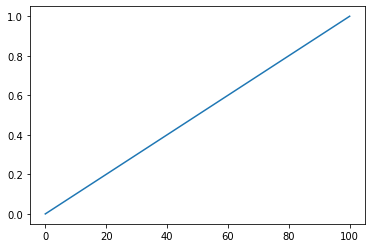

In [329]:
plt.plot(depths)

In [107]:
print(triangle,prism['w_triangle'])

[[-49.1209    3.24894   1.62829]
 [-48.4635    2.99372   2.27014]
 [-49.0948    3.41248   1.74374]] [[-49.1209    3.24894   1.62829]
 [-48.4635    2.99372   2.27014]
 [-49.0948    3.41248   1.74374]]


In [128]:
gray_inplane_vectors = np.array([prism['g_triangle'][2]-prism['g_triangle'][0],
                                     prism['g_triangle'][1]-prism['g_triangle'][0]])
cross_product_gray_inplane_vectors = np.cross(gray_inplane_vectors[1],gray_inplane_vectors[0])


[-0.50795972 -0.44802018  0.35725182]


In [194]:
get_exact_depth(triangle[0],prism1)

array([-9.8494868 , -0.20247424,  0.11722493])

In [187]:
np.dot(cross_product_gray_inplane_vectors,g3-voxel_coord)

26.176639646103254

In [188]:
np.dot(cross_product_gray_inplane_vectors,g3)+ -np.dot(cross_product_gray_inplane_vectors,voxel_coord)

26.176639646103254

In [181]:
np.roots([k0,k1,k2,k3])[0]

(0.5476650386412156+0j)

In [64]:
#ToDo, check for specific ks.
np.cross(connecting_inplane_vectors[0],connecting_inplane_vectors[1])

array([-0.00097954, -0.05834028,  0.03905579])

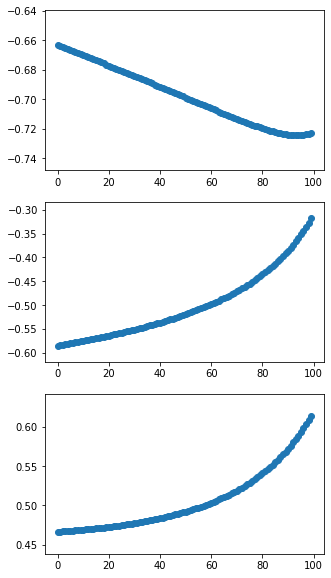

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,10))
plt.subplot(3,1,1)
plt.scatter(np.arange(100),normals[:,0])
plt.subplot(3,1,2)
plt.scatter(np.arange(100),normals[:,1])
plt.subplot(3,1,3)
plt.scatter(np.arange(100),normals[:,2])

In [122]:

world_coords, voxel_coords= voxel_world_coords_in_box(bbox,origin_offset, resolution, dimensions)

In [123]:
voxel_coords

array([[[[589, 632, 632],
         [590, 632, 632],
         [591, 632, 632],
         [592, 632, 632],
         [593, 632, 632],
         [594, 632, 632],
         [595, 632, 632],
         [596, 632, 632],
         [597, 632, 632],
         [598, 632, 632],
         [599, 632, 632],
         [600, 632, 632],
         [601, 632, 632],
         [602, 632, 632],
         [603, 632, 632],
         [604, 632, 632],
         [605, 632, 632],
         [606, 632, 632],
         [607, 632, 632],
         [608, 632, 632],
         [609, 632, 632],
         [610, 632, 632]]]])

In [53]:

np.ceil((bbox[0]-origin_offset)/resolution)
np.floor((bbox[1]-origin_offset)/resolution)

array([548., 461., 732.])

In [57]:
indices_max = np.max((np.min((np.floor((bbox[1]- origin_offset)/resolution), dimensions), axis=0),[0,0,0]), axis=0)
indices_min = np.min((np.max((np.ceil((bbox[0] - origin_offset)/resolution),[0,0,0]),axis=0),dimensions),axis=0)


In [63]:
np.mgrid[indices_max,indices_min]

AttributeError: 'numpy.ndarray' object has no attribute 'step'

In [69]:
np.mgrid[indices_min[0]:indices_max[0],
         indices_min[1]:indices_max[1],
        indices_min[1]:indices_max[1]].T

array([[[[538., 446., 446.],
         [539., 446., 446.],
         [540., 446., 446.],
         ...,
         [545., 446., 446.],
         [546., 446., 446.],
         [547., 446., 446.]],

        [[538., 447., 446.],
         [539., 447., 446.],
         [540., 447., 446.],
         ...,
         [545., 447., 446.],
         [546., 447., 446.],
         [547., 447., 446.]],

        [[538., 448., 446.],
         [539., 448., 446.],
         [540., 448., 446.],
         ...,
         [545., 448., 446.],
         [546., 448., 446.],
         [547., 448., 446.]],

        ...,

        [[538., 458., 446.],
         [539., 458., 446.],
         [540., 458., 446.],
         ...,
         [545., 458., 446.],
         [546., 458., 446.],
         [547., 458., 446.]],

        [[538., 459., 446.],
         [539., 459., 446.],
         [540., 459., 446.],
         ...,
         [545., 459., 446.],
         [546., 459., 446.],
         [547., 459., 446.]],

        [[538., 460., 446.],
       